<a href="https://colab.research.google.com/github/Prasi21/Defence-Force-Monorepo/blob/master/Model_Experiments/rifle_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -qU


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Login to your wandb account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
root = "/content/drive/MyDrive/RifleAction/"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/RifleAction
!ls

/content/gdrive/MyDrive/RifleAction
app.py		 model_all_test.keras	precision_recall_curve_multiclass.png
EF88		 model_label_M4		precision_recall_curve_multilabel.png
evaluate.ipynb	 model_label_M4.h5	requirements.txt
logs		 model_label_M4.keras	RifleAction
M4		 model_m4		share
M4_2-5_CM.jpg	 model_m4_2		temp
model		 model_M4_all.keras	train.ipynb
model_all.keras  model_M4_test-1.keras	wandb


In [ ]:
import datetime
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# from RifleAction import DataLoader, build_model
from keras.models import load_model, Model
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import numpy as np
import pandas as pd
import os
from typing import Tuple, List
from keras import layers, Model, Input

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
class DataLoader:
    def __init__(self, feature_names:List[str] = ['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z'],
                 slide_window_size:int=100, column_labels:List[str]=None) -> None:
        self._features = list()
        self._labels = list()
        self._feature_names = feature_names
        self._slide_window_size:int = slide_window_size
        self._column_labels = column_labels

    def load_data(self, data_path:str, label_description_path:str,):

        # load the raw data
        raw_data = pd.read_csv(data_path)

        # load the label description and create a dictionary to store
        label_description =  pd.read_csv(label_description_path)
        label_dict = {}
        for _, row in label_description.iterrows():
            if row['Action'] not in label_dict.keys():
                label_dict[row['Action']] = list()
                label_dict[row['Action']].append((row['DataStart'], row['DataEnd']))
            else:
                label_dict[row['Action']].append((row['DataStart'], row['DataEnd']))

        # assign label to each sample
        sample_labels = list()
        for index, row in raw_data.iterrows():
            found_action = False
            for key, value in label_dict.items():
                for start, end in value:
                    if index >= start and index <= end:
                        sample_labels.append(key)
                        found_action = True
                        break
                if found_action:
                    break
            if not found_action:
                sample_labels.append('None')
        raw_data['Label'] = sample_labels

        #  extract the features and labels, stripe is 1 for sliding window
        for i in range(len(raw_data)-self.slide_window_size):
            current_window_features = list()
            for feature_name in self.feature_names:
                current_window_features.append(raw_data[feature_name][i:i+self.slide_window_size].values)
            self.features.append(current_window_features)
            # self.labels.append(raw_data['Label'][i:i+self.slide_window_size].value_counts().index[0])
            self.labels.append(raw_data['Label'][i:i+self.slide_window_size].unique())

    def dataset(self):

        features = np.array(self.features)

        # window_labels = pd.DataFrame(self.labels, columns=['Label'])
        # one_hot = pd.get_dummies(window_labels['Label'])
        # one_hot = pd.DataFrame(mlb.fit_transform(self.labels), columns=mlb.classes_)

        if self._column_labels:
          mlb = MultiLabelBinarizer(classes=self._column_labels)
          mlb.fit(self._column_labels)
          one_hot = pd.DataFrame(mlb.transform(self.labels), columns=mlb.classes_)
          # one_hot = one_hot.reindex(columns=self._column_labels, fill_value=0)
        else:
          mlb = MultiLabelBinarizer()
          one_hot = pd.DataFrame(mlb.fit_transform(self.labels), columns=mlb.classes_)


        labels =  one_hot.to_numpy()

        return features, labels, one_hot.columns, mlb

    @property
    def feature_names(self):
        return self._feature_names

    @property
    def features(self):
        return self._features

    @property
    def labels(self):
        return self._labels

    @property
    def slide_window_size(self):
        return self._slide_window_size

In [ ]:
def transformer_encoder(inputs, head_size:int, num_heads:int, ff_dim:int, dropout:float=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape:Tuple,
    n_classes:int,
    head_size:int,
    num_heads:int,
    ff_dim:int,
    num_transformer_blocks:int,
    mlp_units:List[int],
    dropout:float=0,
    mlp_dropout:float=0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return Model(inputs, outputs)

Load the data from M4 Participant 1 - 3

In [ ]:
### Change low ready/aim Approach and multishot to just low ready, aim and shot
# for i in range(1,26):
#         label_path = f"./M4/Participant_5/Labels/{i}.csv"
#         df = pd.read_csv(label_path)
#         df['Action'] = df['Action'].replace("low ready approach", "low ready")
#         df['Action'] = df['Action'].replace("aim approach", "aim")
#         df['Action'] = df['Action'].replace("multishot", "shot")
#         df.to_csv(f"./M4/Participant_5/Labels/{i}.csv")

In [ ]:
# Dataset_ids in form of <gun>_<particpantID>. Eg M4_3
# def load_datasets(dataset_ids, column_labels):

def load_datasets(dataset_ids, column_labels, config=None, win_size=100):
  if config:
      slide_window_size=config.slide_window_size
  else:
      slide_window_size=win_size

  data_formatter = DataLoader(slide_window_size=slide_window_size, column_labels=column_labels)

  for id in dataset_ids:
    gun, participant = id.split("_")
    dir = os.path.join(gun, f"Participant_{participant}")

    num_csv = 0
    for datafile in os.listdir(os.path.join(dir,"Raw_Data")):
          if datafile.endswith(".csv"):
              num_csv += 1

    for i in range(1, num_csv+1):
      data_path = os.path.join(dir,"Raw_Data",f"{i}.csv")
      label_path = os.path.join(dir,"Labels",f"{i}.csv")
      if os.path.exists(data_path) and os.path.exists(label_path):
        data_formatter.load_data(data_path, label_path)
      else:
        print(f"Failed to read {data_path} or labels")

  features, labels, classes, mlb = data_formatter.dataset()
  return features, labels, classes, mlb

In [ ]:
import tensorflow as tf
# import tensorflow_addons as tfa

def create_model(features, config):
  input_shape = features.shape[1:]
  model = build_model(input_shape=input_shape,
                      n_classes=config.num_classes,
                      head_size=config.head_size,
                      num_heads=config.num_heads,
                      ff_dim=config.ff_dim,
                      num_transformer_blocks=config.num_transformer_blocks,
                      mlp_units=config.mlp_units,
                      dropout=config.dropout,
                      mlp_dropout=config.mlp_dropout)

  model.compile(
      loss=config.loss,
      optimizer=Adam(learning_rate=config.learning_rate),
      metrics=["accuracy"],
  )
  return model


Train the model

In [ ]:
def get_dataset_ids(datafile):
  if(datafile == "M4_test-5"):
    train_ids = ["M4_1","M4_2","M4_3","M4_4"]
    test_ids = ["M4_5"]
  if(datafile == "M4_test-4"):
    train_ids = ["M4_1","M4_2","M4_3","M4_5"]
    test_ids = ["M4_4"]
  if(datafile == "M4_test-1"):
    train_ids = ["M4_2","M4_3","M4_4","M4_5"]
    test_ids = ["M4_1"]
  if(datafile == "EF88_test-3"):
    train_ids = ["EF88_1","EF88_2","EF88_4"]
    test_ids = ["EF88_3"]
  if(datafile == "EF88_test-2"):
    train_ids = ["EF88_1","EF88_3","EF88_4"]
    test_ids = ["EF88_2"]
  if(datafile == "All_test_M4-4_EF88-3"):
    train_ids = ["M4_1","M4_2","M4_3","M4_5","EF88_1","EF88_2","EF88_4"]
    test_ids = ["M4_4", "EF88_3"]
  if(datafile == "M4_123_test-4"):
    train_ids = ["M4_1","M4_2","M4_3"]
    test_ids = ["M4_4"]
  if(datafile == "all"):
    train_ids = ["M4_1","M4_2","M4_3","M4_4","M4_5","EF88_1","EF88_2","EF88_3","EF88_4"]
    test_ids = ["M4_4"]
  if(datafile == "M4_all"):
    train_ids = ["M4_1","M4_2","M4_3","M4_4","M4_5"]
    test_ids = ["M4_4"]

  return train_ids, test_ids

In [ ]:
all_classes = ['None', 'aim', 'cocking', 'extreme low ready', 'high ready',
       'low ready', 'magazine change', 'magazine recovery', 'scanning', 'shot']
# low ready approach, aim approach, multishot

In [ ]:
datafiles = [
    "M4_test-1"
    # "M4_all",
    # "all",
    # "M4_test-4",
    # "M4_test-5",
    # "EF88_test-3",
    # "EF88_test-2",
    # "All_test_M4-4_EF88-3"
    # "M4_123_test-4"
    ]

In [ ]:
def print_class_counts(labels, all_classes):
  # Convert one-hot encoded labels to class indices
  class_indices = np.argmax(labels, axis=1)

  # Count the number of instances for each class
  class_counts = {}
  for idx in range(len(all_classes)):
      class_name = all_classes[idx]
      class_count = np.sum(class_indices == idx)
      class_counts[class_name] = class_count

  # Print the number of instances for each class
  for class_name, count in class_counts.items():
      print(f"Class '{class_name}': {count} instances")

In [ ]:
# model.load_weights('temp/checkpoint')

## Running the whole experiment script

In [ ]:
# Train the model on the specified datasets
for datafile in datafiles:

    model_save_path = f"{datafile}_model.h5"
    log_dir = "./logs"

    wandb.init(
      entity="prasi",
      project="defence-force",
      config={
          "architecture": "Transformer Encoder Classification",
          "num_classes":len(all_classes),
          "slide_window_size": 100,
          "head_size": 100,
          "num_heads": 5,
          "ff_dim": 5,
          "num_transformer_blocks": 5,
          "mlp_units": [128,64,32,16],
          "dropout": 0.1,
          "mlp_dropout": 0.1,
          "optimizer": "Adam",
          "loss": "binary_crossentropy",
          "metric": "accuracy",
          "learning_rate": 1e-4,
          "epochs": 1000,
          "batch_size": 64,
          "validation_split": 0.2,
          "dataset": datafile,
      },
    )
    config = wandb.config

    train_ids, test_ids = get_dataset_ids(datafile)
    features, labels, classes, mlb = load_datasets(train_ids, all_classes, config=config)
    print("Train class Counts")
    print_class_counts(labels, classes)
    # x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    test_features, test_labels, test_classes, test_mlb = load_datasets(test_ids, all_classes, config=config)
    print("\nTest class Counts")
    # print_class_counts(test_labels, test_classes)

    print(f"train_ids {train_ids} train classes {classes} len features {len(features)}")
    # print(f"test_ids {test_ids} test classes {test_classes} len features {len(test_features)}")


    model = create_model(features, config)

    # model.load_weights('temp/checkpoint')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_filepath = "temp/checkpoint"
    callbacks = [EarlyStopping(patience=20, monitor="val_loss", mode="min", restore_best_weights=True),
                #  TensorBoard(log_dir=log_dir, histogram_freq=1),
                 WandbMetricsLogger(),
                #  WandbModelCheckpoint(filepath= "/content/" + datafile),  # "_{epoch:02d}",
                #  ModelCheckpoint(
                #     filepath=checkpoint_filepath,
                #     save_weights_only=True,
                #     monitor='accuracy',
                #     mode='max',
                #     save_best_only=True),
                 tf.keras.callbacks.BackupAndRestore(backup_dir=checkpoint_filepath)
                ]

    history = model.fit(
        features,
        labels,
        # validation_split=config.validation_split,
        validation_data=(test_features, test_labels),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
    )
    model.save("./model_M4_test-1.keras", overwrite=True)
    # Mark the run as finished
    wandb.finish()


wandb: Currently logged in as: prasi. Use `wandb login --relogin` to force relogin


Train class Counts
Class 'None': 73382 instances
Class 'aim': 9968 instances
Class 'cocking': 3150 instances
Class 'extreme low ready': 6091 instances
Class 'high ready': 6109 instances
Class 'low ready': 4610 instances
Class 'magazine change': 1037 instances
Class 'magazine recovery': 3428 instances
Class 'scanning': 4692 instances
Class 'shot': 0 instances

Test class Counts
train_ids ['M4_2', 'M4_3', 'M4_4', 'M4_5'] train classes Index(['None', 'aim', 'cocking', 'extreme low ready', 'high ready',
       'low ready', 'magazine change', 'magazine recovery', 'scanning',
       'shot'],
      dtype='object') len features 112467
Epoch 1/1000
1758/1758 [==============================] - 78s 28ms/step - loss: 0.4344 - accuracy: 0.5477 - val_loss: 0.3535 - val_accuracy: 0.5843
Epoch 2/1000
1758/1758 [==============================] - 49s 28ms/step - loss: 0.3290 - accuracy: 0.6218 - val_loss: 0.3407 - val_accuracy: 0.5511
Epoch 3/1000
1758/1758 [==============================] - 52s 30ms/st

epoch/accuracy,▁▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇██████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▄▁▁▄▄▄▄▆▇█▇▇▆█▇▆▇▇▇▆▇▆█▇█▅▆
epoch/val_loss,█▆▄▃▂▂▁▁▂▁▃▂▃▂▃▂▂▃▄▄▅▅▅▆▄▇█
epoch/accuracy,0.72533
epoch/epoch,26
epoch/learning_rate,0.0001
epoch/loss,0.16373
epoch/val_accuracy,0.61071


In [ ]:
  train_ids, test_ids = get_dataset_ids(datafiles[0])
  features, labels, classes, mlb = load_datasets(train_ids, all_classes, config=None)
  test_features, test_labels, test_classes, test_mlb = load_datasets(test_ids, all_classes, config=None)


In [ ]:
mlb = MultiLabelBinarizer(classes = all_classes)
mlb.fit(all_classes)
print(mlb.classes_)
i = 5000
k = 10
print(test_labels[i:i+k])
predictions = model.predict(test_features[i:i+k])
threshold = 0.5
binary_pred = np.array(predictions > threshold).astype(int)
print(binary_pred)

ground_truth = mlb.inverse_transform(np.array(test_labels[i:i+k]))

# Inverse transform the binary predictions to the original multilabel format
original_predictions = mlb.inverse_transform(binary_pred)

print("Ground Truth:", ground_truth)
print("Original Predictions:", original_predictions)


NameError: ignored

In [ ]:
model.evaluate(test_features, test_labels)

822/822 [==============================] - 4s 4ms/step - loss: 0.2829 - accuracy: 0.6896


[0.28289365768432617, 0.6896066069602966]

In [ ]:
y_pred = model.predict(test_features)
one_hot_encoded = np.zeros_like(y_pred)
one_hot_encoded[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
binary_pred = one_hot_encoded

822/822 [==============================] - 3s 3ms/step


In [ ]:
from sklearn.metrics import precision_score
y_pred = model.predict(test_features)
threshold = 0.5
y_pred = np.array(y_pred > threshold).astype(int)




822/822 [==============================] - 3s 3ms/step


In [ ]:
class_index = 4
print(mlb.classes_[class_index])
precision = precision_score(test_labels[:, class_index], y_pred[:, class_index], average='binary')
print(precision)

high ready
0.7273123909249564


In [ ]:
wandb.finish()


epoch/accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.9599
epoch/epoch,157
epoch/learning_rate,0.0001
epoch/loss,0.11931


In [ ]:
    model.save("./model_label_M4_test_1.keras", overwrite=True)


# Parameter Sweep

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_f1_score',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'value': 60
         },
        "num_transformer_blocks": {
            'values': [2, 4, 6, 8, 10]
        },
        "head_size": {
            'values': [32, 64, 128, 256],
        },
        "num_heads": {
            'values': [4, 8, 16, 32]
        },
        "ff_dim": {
            'values': [4, 16, 32, 64, 128]
        },
        "mlp_units": {
            'values': [[128,64,32,16], [128, 64, 32], [64, 32, 16], [128, 64]]
        },
        "dropout": {
            'values': [0.1, 0.3, 0.5]
        },
        "mlp_dropout": {
            'values': [0.1, 0.3, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4, 3e-5]
        },
    }
}


In [ ]:
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback

datafile = "M4_test-4"


default_config={
    "architecture": "Transformer Encoder Classification",
    "num_classes":len(all_classes),
    "slide_window_size": 25,
    "optimizer": "Adam",
    "loss": "categorical_crossentropy",
    "metric": "weighted_f1",
    "batch_size": 64,
    "validation_split": 0.2,
    "dataset": datafile,
}

def train():
    model_save_path = f"{datafile}_model.h5"

    # Merge default configuration with sweep configuration
    wandb.init(
        config={**default_config, **sweep_config},
        project="defence-force",
    )

    config = wandb.config

    train_ids, test_ids = get_dataset_ids(config.dataset)
    features, labels, classes = load_datasets(train_ids, all_classes, config=config)

    test_features, test_labels, test_classes = load_datasets(test_ids, all_classes, config=config)

    model = create_model(features, config)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_filepath = "temp/checkpoint."
    callbacks = [
        EarlyStopping(patience=10, monitor="val_f1_score", mode="max", restore_best_weights=True),
        WandbCallback(),
        ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='f1_score',
            mode='max',
            save_best_only=True
        )
    ]

    history = model.fit(
        features,
        labels,
        validation_data=(test_features, test_labels),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
    )

    # wandb.finish()



In [ ]:
# Assuming you already have the sweep_config defined
sweep_id = wandb.sweep(sweep_config, project="defence-force")
sweep_id = 'k5lpmxhw'

# Run the sweep
wandb.agent(sweep_id, train)


Create sweep with ID: 7acj3zpx
Sweep URL: https://wandb.ai/remchat/defence-force/sweeps/7acj3zpx


wandb: Agent Starting Run: lfxhnl6w with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 60
wandb: 	ff_dim: 32
wandb: 	head_size: 128
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [64, 32, 16]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2910 - accuracy: 0.5090 - f1_score: 0.4704

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_062607-lfxhnl6w/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 147s 74ms/step - loss: 1.2910 - accuracy: 0.5090 - f1_score: 0.4704 - val_loss: 1.0668 - val_accuracy: 0.5465 - val_f1_score: 0.4927
Epoch 2/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0038 - accuracy: 0.6071 - f1_score: 0.5779

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_062607-lfxhnl6w/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 133s 73ms/step - loss: 1.0038 - accuracy: 0.6071 - f1_score: 0.5779 - val_loss: 0.9821 - val_accuracy: 0.6078 - val_f1_score: 0.5868
Epoch 3/60
1818/1818 [==============================] - 110s 60ms/step - loss: 0.9253 - accuracy: 0.6378 - f1_score: 0.6158 - val_loss: 0.9872 - val_accuracy: 0.6178 - val_f1_score: 0.5993
Epoch 4/60
1818/1818 [==============================] - 111s 61ms/step - loss: 0.8757 - accuracy: 0.6575 - f1_score: 0.6406 - val_loss: 0.9932 - val_accuracy: 0.6115 - val_f1_score: 0.6076
Epoch 5/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8509 - accuracy: 0.6644 - f1_score: 0.6502

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_062607-lfxhnl6w/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 132s 72ms/step - loss: 0.8509 - accuracy: 0.6644 - f1_score: 0.6502 - val_loss: 0.9497 - val_accuracy: 0.6486 - val_f1_score: 0.6396
Epoch 6/60
1818/1818 [==============================] - 110s 60ms/step - loss: 0.8273 - accuracy: 0.6731 - f1_score: 0.6621 - val_loss: 0.9885 - val_accuracy: 0.6346 - val_f1_score: 0.6359
Epoch 7/60
1818/1818 [==============================] - 110s 61ms/step - loss: 0.8156 - accuracy: 0.6798 - f1_score: 0.6708 - val_loss: 0.9780 - val_accuracy: 0.6370 - val_f1_score: 0.6374
Epoch 8/60
1818/1818 [==============================] - 110s 61ms/step - loss: 0.8114 - accuracy: 0.6813 - f1_score: 0.6722 - val_loss: 0.9834 - val_accuracy: 0.6435 - val_f1_score: 0.6398
Epoch 9/60
1818/1818 [==============================] - 111s 61ms/step - loss: 0.7996 - accuracy: 0.6868 - f1_score: 0.6789 - val_loss: 1.0636 - val_accuracy: 0.6101 - val_f1_score: 0.6120
Epoch 10/60
1818/1818 [==============================] - 109s 60ms

accuracy,▁▄▅▆▆▇▇▇▇▇▇███████
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
f1_score,▁▄▅▆▆▇▇▇▇▇▇███████
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▆▅█▇▇█▅▆▃▇▄▅▄▅▄▄
val_f1_score,▁▅▆▆████▇▇▅▇▅▆▆▆▆▆
val_loss,▅▂▂▂▁▂▂▂▅▄█▄▆▆▇▇▇▇
accuracy,0.71066
best_epoch,4
best_val_loss,0.94972
epoch,17


wandb: Agent Starting Run: xn61xvgi with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 4
wandb: 	head_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [64, 32, 16]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.8832 - accuracy: 0.3472 - f1_score: 0.1935

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 111s 55ms/step - loss: 1.8832 - accuracy: 0.3472 - f1_score: 0.1935 - val_loss: 1.7136 - val_accuracy: 0.3759 - val_f1_score: 0.2123
Epoch 2/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.5739 - accuracy: 0.4185 - f1_score: 0.3366

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 97s 53ms/step - loss: 1.5739 - accuracy: 0.4185 - f1_score: 0.3366 - val_loss: 1.3975 - val_accuracy: 0.4665 - val_f1_score: 0.3533
Epoch 3/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4023 - accuracy: 0.4726 - f1_score: 0.4188

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 99s 54ms/step - loss: 1.4023 - accuracy: 0.4726 - f1_score: 0.4188 - val_loss: 1.2701 - val_accuracy: 0.4874 - val_f1_score: 0.3928
Epoch 4/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.4989 - f1_score: 0.4547

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 105s 58ms/step - loss: 1.3075 - accuracy: 0.4989 - f1_score: 0.4547 - val_loss: 1.2049 - val_accuracy: 0.4835 - val_f1_score: 0.4035
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2353 - accuracy: 0.5239 - f1_score: 0.4843

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 98s 54ms/step - loss: 1.2353 - accuracy: 0.5239 - f1_score: 0.4843 - val_loss: 1.1406 - val_accuracy: 0.4993 - val_f1_score: 0.4202
Epoch 6/60
1818/1818 [==============================] - 75s 41ms/step - loss: 1.1863 - accuracy: 0.5433 - f1_score: 0.5052 - val_loss: 1.1473 - val_accuracy: 0.5075 - val_f1_score: 0.4397
Epoch 7/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1408 - accuracy: 0.5584 - f1_score: 0.5218

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 96s 53ms/step - loss: 1.1408 - accuracy: 0.5584 - f1_score: 0.5218 - val_loss: 1.0885 - val_accuracy: 0.5153 - val_f1_score: 0.4463
Epoch 8/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1108 - accuracy: 0.5700 - f1_score: 0.5341

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 95s 52ms/step - loss: 1.1107 - accuracy: 0.5700 - f1_score: 0.5341 - val_loss: 1.0798 - val_accuracy: 0.5298 - val_f1_score: 0.4609
Epoch 9/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0839 - accuracy: 0.5821 - f1_score: 0.5466

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 99s 55ms/step - loss: 1.0839 - accuracy: 0.5821 - f1_score: 0.5466 - val_loss: 1.0686 - val_accuracy: 0.5181 - val_f1_score: 0.4540
Epoch 10/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0593 - accuracy: 0.5905 - f1_score: 0.5562

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 96s 53ms/step - loss: 1.0594 - accuracy: 0.5905 - f1_score: 0.5562 - val_loss: 1.0675 - val_accuracy: 0.5242 - val_f1_score: 0.4551
Epoch 11/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.5998 - f1_score: 0.5658

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 94s 52ms/step - loss: 1.0387 - accuracy: 0.5998 - f1_score: 0.5657 - val_loss: 1.0551 - val_accuracy: 0.5270 - val_f1_score: 0.4606
Epoch 12/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0179 - accuracy: 0.6073 - f1_score: 0.5735

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 100s 55ms/step - loss: 1.0179 - accuracy: 0.6073 - f1_score: 0.5735 - val_loss: 1.0432 - val_accuracy: 0.5306 - val_f1_score: 0.4776
Epoch 13/60
1818/1818 [==============================] - 75s 41ms/step - loss: 1.0044 - accuracy: 0.6107 - f1_score: 0.5777 - val_loss: 1.0490 - val_accuracy: 0.5195 - val_f1_score: 0.4589
Epoch 14/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.6176 - f1_score: 0.5856

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 97s 53ms/step - loss: 0.9869 - accuracy: 0.6176 - f1_score: 0.5856 - val_loss: 1.0311 - val_accuracy: 0.5157 - val_f1_score: 0.4681
Epoch 15/60
1818/1818 [==============================] - 79s 43ms/step - loss: 0.9747 - accuracy: 0.6221 - f1_score: 0.5911 - val_loss: 1.0383 - val_accuracy: 0.5071 - val_f1_score: 0.4667
Epoch 16/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9601 - accuracy: 0.6259 - f1_score: 0.5964

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 94s 52ms/step - loss: 0.9601 - accuracy: 0.6260 - f1_score: 0.5965 - val_loss: 1.0125 - val_accuracy: 0.5251 - val_f1_score: 0.4873
Epoch 17/60
1818/1818 [==============================] - 75s 41ms/step - loss: 0.9506 - accuracy: 0.6297 - f1_score: 0.6012 - val_loss: 1.0226 - val_accuracy: 0.5216 - val_f1_score: 0.4826
Epoch 18/60
1818/1818 [==============================] - 76s 42ms/step - loss: 0.9365 - accuracy: 0.6338 - f1_score: 0.6058 - val_loss: 1.0289 - val_accuracy: 0.5128 - val_f1_score: 0.4761
Epoch 19/60
1818/1818 [==============================] - 76s 42ms/step - loss: 0.9248 - accuracy: 0.6382 - f1_score: 0.6119 - val_loss: 1.0255 - val_accuracy: 0.5271 - val_f1_score: 0.4993
Epoch 20/60
1818/1818 [==============================] - 79s 44ms/step - loss: 0.9124 - accuracy: 0.6415 - f1_score: 0.6165 - val_loss: 1.0266 - val_accuracy: 0.5188 - val_f1_score: 0.4827
Epoch 21/60
1818/1818 [==============================] - 76s 42ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 92s 51ms/step - loss: 0.8490 - accuracy: 0.6649 - f1_score: 0.6493 - val_loss: 1.0057 - val_accuracy: 0.5788 - val_f1_score: 0.5652
Epoch 29/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.6680 - f1_score: 0.6532

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 96s 53ms/step - loss: 0.8393 - accuracy: 0.6680 - f1_score: 0.6532 - val_loss: 0.9979 - val_accuracy: 0.5822 - val_f1_score: 0.5672
Epoch 30/60
1818/1818 [==============================] - 72s 40ms/step - loss: 0.8348 - accuracy: 0.6702 - f1_score: 0.6568 - val_loss: 1.0084 - val_accuracy: 0.5811 - val_f1_score: 0.5643
Epoch 31/60
1818/1818 [==============================] - 73s 40ms/step - loss: 0.8316 - accuracy: 0.6728 - f1_score: 0.6592 - val_loss: 1.0069 - val_accuracy: 0.5727 - val_f1_score: 0.5544
Epoch 32/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8218 - accuracy: 0.6745 - f1_score: 0.6626

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 93s 51ms/step - loss: 0.8218 - accuracy: 0.6745 - f1_score: 0.6626 - val_loss: 0.9919 - val_accuracy: 0.6107 - val_f1_score: 0.5975
Epoch 33/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8162 - accuracy: 0.6777 - f1_score: 0.6664

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 93s 51ms/step - loss: 0.8162 - accuracy: 0.6777 - f1_score: 0.6665 - val_loss: 0.9885 - val_accuracy: 0.6031 - val_f1_score: 0.5900
Epoch 34/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8107 - accuracy: 0.6813 - f1_score: 0.6706

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 95s 52ms/step - loss: 0.8106 - accuracy: 0.6813 - f1_score: 0.6706 - val_loss: 0.9693 - val_accuracy: 0.6237 - val_f1_score: 0.6106
Epoch 35/60
1818/1818 [==============================] - 74s 41ms/step - loss: 0.8029 - accuracy: 0.6831 - f1_score: 0.6731 - val_loss: 0.9772 - val_accuracy: 0.6162 - val_f1_score: 0.6032
Epoch 36/60
1818/1818 [==============================] - 73s 40ms/step - loss: 0.8003 - accuracy: 0.6856 - f1_score: 0.6759 - val_loss: 0.9733 - val_accuracy: 0.6206 - val_f1_score: 0.6118
Epoch 37/60
1818/1818 [==============================] - 75s 41ms/step - loss: 0.7956 - accuracy: 0.6880 - f1_score: 0.6790 - val_loss: 0.9864 - val_accuracy: 0.6007 - val_f1_score: 0.5861
Epoch 38/60
1818/1818 [==============================] - 77s 42ms/step - loss: 0.7883 - accuracy: 0.6894 - f1_score: 0.6805 - val_loss: 0.9909 - val_accuracy: 0.5980 - val_f1_score: 0.5841
Epoch 39/60
1818/1818 [==============================] - 77s 42ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 92s 51ms/step - loss: 0.7809 - accuracy: 0.6945 - f1_score: 0.6869 - val_loss: 0.9466 - val_accuracy: 0.6291 - val_f1_score: 0.6175
Epoch 41/60
1818/1818 [==============================] - 73s 40ms/step - loss: 0.7748 - accuracy: 0.6970 - f1_score: 0.6895 - val_loss: 0.9541 - val_accuracy: 0.6199 - val_f1_score: 0.6072
Epoch 42/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7737 - accuracy: 0.6974 - f1_score: 0.6903

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 92s 51ms/step - loss: 0.7737 - accuracy: 0.6975 - f1_score: 0.6903 - val_loss: 0.9389 - val_accuracy: 0.6268 - val_f1_score: 0.6155
Epoch 43/60
1818/1818 [==============================] - 73s 40ms/step - loss: 0.7665 - accuracy: 0.6996 - f1_score: 0.6928 - val_loss: 0.9393 - val_accuracy: 0.6319 - val_f1_score: 0.6224
Epoch 44/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.7010 - f1_score: 0.6946

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 94s 52ms/step - loss: 0.7636 - accuracy: 0.7010 - f1_score: 0.6945 - val_loss: 0.9252 - val_accuracy: 0.6331 - val_f1_score: 0.6230
Epoch 45/60
1818/1818 [==============================] - 77s 42ms/step - loss: 0.7582 - accuracy: 0.7023 - f1_score: 0.6960 - val_loss: 0.9403 - val_accuracy: 0.6279 - val_f1_score: 0.6196
Epoch 46/60
1818/1818 [==============================] - 72s 40ms/step - loss: 0.7539 - accuracy: 0.7041 - f1_score: 0.6980 - val_loss: 0.9617 - val_accuracy: 0.6162 - val_f1_score: 0.6060
Epoch 47/60
1818/1818 [==============================] - 72s 39ms/step - loss: 0.7525 - accuracy: 0.7068 - f1_score: 0.7008 - val_loss: 0.9512 - val_accuracy: 0.6154 - val_f1_score: 0.6067
Epoch 48/60
1818/1818 [==============================] - 74s 41ms/step - loss: 0.7456 - accuracy: 0.7092 - f1_score: 0.7036 - val_loss: 0.9436 - val_accuracy: 0.6280 - val_f1_score: 0.6213
Epoch 49/60
1818/1818 [==============================] - 72s 40ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_070255-xn61xvgi/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 90s 50ms/step - loss: 0.7359 - accuracy: 0.7127 - f1_score: 0.7078 - val_loss: 0.9225 - val_accuracy: 0.6438 - val_f1_score: 0.6396
Epoch 52/60
1818/1818 [==============================] - 74s 41ms/step - loss: 0.7315 - accuracy: 0.7142 - f1_score: 0.7096 - val_loss: 0.9539 - val_accuracy: 0.6298 - val_f1_score: 0.6306
Epoch 53/60
1818/1818 [==============================] - 73s 40ms/step - loss: 0.7305 - accuracy: 0.7148 - f1_score: 0.7100 - val_loss: 0.9553 - val_accuracy: 0.6316 - val_f1_score: 0.6273
Epoch 54/60
1818/1818 [==============================] - 74s 41ms/step - loss: 0.7265 - accuracy: 0.7165 - f1_score: 0.7116 - val_loss: 0.9340 - val_accuracy: 0.6327 - val_f1_score: 0.6319
Epoch 55/60
1818/1818 [==============================] - 72s 40ms/step - loss: 0.7237 - accuracy: 0.7163 - f1_score: 0.7116 - val_loss: 0.9290 - val_accuracy: 0.6394 - val_f1_score: 0.6361
Epoch 56/60
1818/1818 [==============================] - 72s 39ms/s

accuracy,▁▂▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█▇██▇▇████████
val_f1_score,▁▃▄▄▅▅▅▅▅▅▅▅▆▅▅▆▆▆▇▇▇▇▇▇▇▇█▇██▇▇████████
val_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.72258
best_epoch,50
best_val_loss,0.92251
epoch,59


wandb: Agent Starting Run: 3xqqrp3k with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 60
wandb: 	ff_dim: 16
wandb: 	head_size: 32
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.5
wandb: 	mlp_units: [128, 64, 32]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.5202 - accuracy: 0.4351 - f1_score: 0.3764

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 31s 15ms/step - loss: 1.5202 - accuracy: 0.4351 - f1_score: 0.3764 - val_loss: 1.1493 - val_accuracy: 0.4943 - val_f1_score: 0.3986
Epoch 2/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1943 - accuracy: 0.5374 - f1_score: 0.4930

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 28s 16ms/step - loss: 1.1943 - accuracy: 0.5374 - f1_score: 0.4930 - val_loss: 1.0958 - val_accuracy: 0.5328 - val_f1_score: 0.4481
Epoch 3/60
1814/1818 [============================>.] - ETA: 0s - loss: 1.1183 - accuracy: 0.5668 - f1_score: 0.5253

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 30s 16ms/step - loss: 1.1185 - accuracy: 0.5668 - f1_score: 0.5253 - val_loss: 1.0588 - val_accuracy: 0.5385 - val_f1_score: 0.4678
Epoch 4/60
1813/1818 [============================>.] - ETA: 0s - loss: 1.0695 - accuracy: 0.5889 - f1_score: 0.5486

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 27s 15ms/step - loss: 1.0693 - accuracy: 0.5890 - f1_score: 0.5487 - val_loss: 1.0573 - val_accuracy: 0.5364 - val_f1_score: 0.4647
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0413 - accuracy: 0.6018 - f1_score: 0.5616

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 28s 15ms/step - loss: 1.0413 - accuracy: 0.6018 - f1_score: 0.5616 - val_loss: 1.0189 - val_accuracy: 0.5447 - val_f1_score: 0.4721
Epoch 6/60
1818/1818 [==============================] - 22s 12ms/step - loss: 1.0179 - accuracy: 0.6106 - f1_score: 0.5710 - val_loss: 1.0483 - val_accuracy: 0.5373 - val_f1_score: 0.4697
Epoch 7/60
1818/1818 [==============================] - 20s 11ms/step - loss: 1.0016 - accuracy: 0.6164 - f1_score: 0.5766 - val_loss: 1.0496 - val_accuracy: 0.5621 - val_f1_score: 0.5039
Epoch 8/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.9864 - accuracy: 0.6216 - f1_score: 0.5824 - val_loss: 1.0625 - val_accuracy: 0.5340 - val_f1_score: 0.4590
Epoch 9/60
1818/1818 [==============================] - 23s 12ms/step - loss: 0.9763 - accuracy: 0.6285 - f1_score: 0.5884 - val_loss: 1.0223 - val_accuracy: 0.5436 - val_f1_score: 0.4688
Epoch 10/60
1818/1818 [==============================] - 23s 13ms/step 

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.9652 - accuracy: 0.6316 - f1_score: 0.5927 - val_loss: 1.0148 - val_accuracy: 0.5817 - val_f1_score: 0.5191
Epoch 12/60
1818/1818 [==============================] - 21s 11ms/step - loss: 0.9569 - accuracy: 0.6359 - f1_score: 0.5978 - val_loss: 1.0592 - val_accuracy: 0.5417 - val_f1_score: 0.4737
Epoch 13/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9498 - accuracy: 0.6396 - f1_score: 0.6013

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_082750-3xqqrp3k/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 15ms/step - loss: 0.9498 - accuracy: 0.6396 - f1_score: 0.6012 - val_loss: 0.9904 - val_accuracy: 0.6018 - val_f1_score: 0.5385
Epoch 14/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.9468 - accuracy: 0.6397 - f1_score: 0.6019 - val_loss: 1.0278 - val_accuracy: 0.5828 - val_f1_score: 0.5213
Epoch 15/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.9388 - accuracy: 0.6423 - f1_score: 0.6067 - val_loss: 1.0340 - val_accuracy: 0.5749 - val_f1_score: 0.5134
Epoch 16/60
1818/1818 [==============================] - 21s 12ms/step - loss: 0.9377 - accuracy: 0.6438 - f1_score: 0.6098 - val_loss: 1.0158 - val_accuracy: 0.5775 - val_f1_score: 0.5155
Epoch 17/60
1818/1818 [==============================] - 25s 14ms/step - loss: 0.9338 - accuracy: 0.6443 - f1_score: 0.6092 - val_loss: 1.0871 - val_accuracy: 0.5482 - val_f1_score: 0.4791
Epoch 18/60
1818/1818 [==============================] - 20s 11ms/s

accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
f1_score,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▃▃▃▄▃▃▄▅▃▆▅▅▅▃▃▃▄▅▅▃▆▆▆▄▅▅▆█▆▅▅▇▇▃▄▆▇
val_f1_score,▁▂▃▃▃▃▄▃▃▄▅▃▅▅▄▅▃▄▃▄▆▆▃▇▆▇▄▆▆▆█▇▆▆██▃▄▆█
val_loss,█▆▄▄▂▄▄▄▂▃▂▄▁▃▃▂▅▅▄▆▆▆▅▅▂▆▆▅▄▆▂▄▅▆▄▃▆▆▄▃
accuracy,0.66038
best_epoch,12
best_val_loss,0.99045
epoch,40


wandb: Agent Starting Run: lg874y30 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 16
wandb: 	head_size: 32
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [128, 64, 32]
wandb: 	num_heads: 4
wandb: 	num_transformer_blocks: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1106 - accuracy: 0.5809 - f1_score: 0.5572

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_084543-lg874y30/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 31s 16ms/step - loss: 1.1105 - accuracy: 0.5810 - f1_score: 0.5573 - val_loss: 1.0194 - val_accuracy: 0.5931 - val_f1_score: 0.5912
Epoch 2/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.8366 - accuracy: 0.6756 - f1_score: 0.6641 - val_loss: 1.1278 - val_accuracy: 0.5548 - val_f1_score: 0.5537
Epoch 3/60
1818/1818 [==============================] - 21s 12ms/step - loss: 0.7590 - accuracy: 0.7071 - f1_score: 0.6988 - val_loss: 1.1723 - val_accuracy: 0.5665 - val_f1_score: 0.5678
Epoch 4/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.7117 - accuracy: 0.7249 - f1_score: 0.7187 - val_loss: 1.1688 - val_accuracy: 0.5846 - val_f1_score: 0.5887
Epoch 5/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.6752 - accuracy: 0.7404 - f1_score: 0.7354 - val_loss: 1.2907 - val_accuracy: 0.5438 - val_f1_score: 0.5517
Epoch 6/60
1818/1818 [==============================] - 21s 12ms/step -

accuracy,▁▄▅▆▇▇▇▇███
epoch,▁▂▂▃▄▅▅▆▇▇█
f1_score,▁▄▅▆▇▇▇▇███
loss,█▄▃▃▂▂▂▂▁▁▁
val_accuracy,█▄▅▇▂▄▄▂▁▄▂
val_f1_score,█▂▅█▂▄▅▂▁▅▁
val_loss,▁▂▃▃▄▄▅▆▇▅█
accuracy,0.78072
best_epoch,0
best_val_loss,1.01941
epoch,10


wandb: Agent Starting Run: whozdtex with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 60
wandb: 	ff_dim: 4
wandb: 	head_size: 32
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [128, 64, 32]
wandb: 	num_heads: 8
wandb: 	num_transformer_blocks: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1199 - accuracy: 0.5736 - f1_score: 0.5505

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_085211-whozdtex/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 77s 38ms/step - loss: 1.1198 - accuracy: 0.5736 - f1_score: 0.5505 - val_loss: 1.0006 - val_accuracy: 0.5821 - val_f1_score: 0.5535
Epoch 2/60
1818/1818 [==============================] - 56s 31ms/step - loss: 0.8373 - accuracy: 0.6751 - f1_score: 0.6620 - val_loss: 1.0267 - val_accuracy: 0.5971 - val_f1_score: 0.5949
Epoch 3/60
1818/1818 [==============================] - 53s 29ms/step - loss: 0.7464 - accuracy: 0.7059 - f1_score: 0.6987 - val_loss: 1.0083 - val_accuracy: 0.6112 - val_f1_score: 0.6105
Epoch 4/60
1818/1818 [==============================] - 54s 30ms/step - loss: 0.6937 - accuracy: 0.7267 - f1_score: 0.7221 - val_loss: 1.0033 - val_accuracy: 0.6073 - val_f1_score: 0.6135
Epoch 5/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.6572 - accuracy: 0.7406 - f1_score: 0.7375 - val_loss: 1.0340 - val_accuracy: 0.6307 - val_f1_score: 0.6362
Epoch 6/60
1818/1818 [==============================] - 54s 29ms/step -

accuracy,▁▄▅▆▆▇▇▇▇▇▇▇██████
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
f1_score,▁▄▅▆▆▇▇▇▇▇▇███████
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▄▅▆▆▇▃▄█▆█▅▆▄▅▁▅▆▅
val_f1_score,▁▄▅▅▇▃▄█▆▇▅▆▄▄▁▅▆▄
val_loss,▁▂▁▁▂▄▄▂▄▃▅▄▆▆█▇▆▇
accuracy,0.80003
best_epoch,0
best_val_loss,1.00058
epoch,17


wandb: Agent Starting Run: cegxday5 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 60
wandb: 	ff_dim: 4
wandb: 	head_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	mlp_dropout: 0.3
wandb: 	mlp_units: [128, 64]
wandb: 	num_heads: 8
wandb: 	num_transformer_blocks: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1813/1818 [============================>.] - ETA: 0s - loss: 1.7848 - accuracy: 0.3687 - f1_score: 0.2798

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 28s 14ms/step - loss: 1.7838 - accuracy: 0.3690 - f1_score: 0.2803 - val_loss: 1.4105 - val_accuracy: 0.4409 - val_f1_score: 0.3385
Epoch 2/60
1814/1818 [============================>.] - ETA: 0s - loss: 1.4121 - accuracy: 0.4733 - f1_score: 0.4314

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 27s 15ms/step - loss: 1.4120 - accuracy: 0.4733 - f1_score: 0.4314 - val_loss: 1.2604 - val_accuracy: 0.4769 - val_f1_score: 0.3902
Epoch 3/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5169 - f1_score: 0.4813

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 1.2835 - accuracy: 0.5169 - f1_score: 0.4813 - val_loss: 1.1856 - val_accuracy: 0.4901 - val_f1_score: 0.4063
Epoch 4/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1983 - accuracy: 0.5464 - f1_score: 0.5122

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 27s 15ms/step - loss: 1.1982 - accuracy: 0.5464 - f1_score: 0.5123 - val_loss: 1.1263 - val_accuracy: 0.5332 - val_f1_score: 0.4648
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1370 - accuracy: 0.5675 - f1_score: 0.5343

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 27s 15ms/step - loss: 1.1370 - accuracy: 0.5675 - f1_score: 0.5343 - val_loss: 1.0674 - val_accuracy: 0.5702 - val_f1_score: 0.5174
Epoch 6/60
1813/1818 [============================>.] - ETA: 0s - loss: 1.0895 - accuracy: 0.5852 - f1_score: 0.5537

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 25s 14ms/step - loss: 1.0895 - accuracy: 0.5852 - f1_score: 0.5537 - val_loss: 1.0616 - val_accuracy: 0.5461 - val_f1_score: 0.4978
Epoch 7/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.5976 - f1_score: 0.5670

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 1.0532 - accuracy: 0.5976 - f1_score: 0.5670 - val_loss: 1.0486 - val_accuracy: 0.5568 - val_f1_score: 0.5245
Epoch 8/60
1813/1818 [============================>.] - ETA: 0s - loss: 1.0241 - accuracy: 0.6073 - f1_score: 0.5787

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 25s 14ms/step - loss: 1.0244 - accuracy: 0.6072 - f1_score: 0.5785 - val_loss: 1.0471 - val_accuracy: 0.5482 - val_f1_score: 0.5092
Epoch 9/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0012 - accuracy: 0.6162 - f1_score: 0.5880

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 25s 14ms/step - loss: 1.0012 - accuracy: 0.6162 - f1_score: 0.5880 - val_loss: 1.0343 - val_accuracy: 0.5600 - val_f1_score: 0.5225
Epoch 10/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.9783 - accuracy: 0.6245 - f1_score: 0.5972 - val_loss: 1.0351 - val_accuracy: 0.5637 - val_f1_score: 0.5350
Epoch 11/60
1814/1818 [============================>.] - ETA: 0s - loss: 0.9627 - accuracy: 0.6289 - f1_score: 0.6026

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 24s 13ms/step - loss: 0.9625 - accuracy: 0.6290 - f1_score: 0.6027 - val_loss: 1.0165 - val_accuracy: 0.5693 - val_f1_score: 0.5450
Epoch 12/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9440 - accuracy: 0.6354 - f1_score: 0.6100

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 28s 16ms/step - loss: 0.9441 - accuracy: 0.6354 - f1_score: 0.6100 - val_loss: 1.0067 - val_accuracy: 0.5602 - val_f1_score: 0.5353
Epoch 13/60
1816/1818 [============================>.] - ETA: 0s - loss: 0.9304 - accuracy: 0.6399 - f1_score: 0.6156

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.9303 - accuracy: 0.6400 - f1_score: 0.6157 - val_loss: 1.0024 - val_accuracy: 0.5795 - val_f1_score: 0.5636
Epoch 14/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.9172 - accuracy: 0.6442 - f1_score: 0.6211 - val_loss: 1.0037 - val_accuracy: 0.5814 - val_f1_score: 0.5697
Epoch 15/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9062 - accuracy: 0.6485 - f1_score: 0.6261

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.9062 - accuracy: 0.6485 - f1_score: 0.6261 - val_loss: 0.9891 - val_accuracy: 0.5792 - val_f1_score: 0.5602
Epoch 16/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.8911 - accuracy: 0.6535 - f1_score: 0.6326 - val_loss: 0.9983 - val_accuracy: 0.5879 - val_f1_score: 0.5816
Epoch 17/60
1816/1818 [============================>.] - ETA: 0s - loss: 0.8793 - accuracy: 0.6563 - f1_score: 0.6372

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.8791 - accuracy: 0.6564 - f1_score: 0.6372 - val_loss: 0.9708 - val_accuracy: 0.5973 - val_f1_score: 0.5897
Epoch 18/60
1818/1818 [==============================] - 21s 12ms/step - loss: 0.8714 - accuracy: 0.6602 - f1_score: 0.6419 - val_loss: 1.0007 - val_accuracy: 0.5894 - val_f1_score: 0.5849
Epoch 19/60
1818/1818 [==============================] - 24s 13ms/step - loss: 0.8609 - accuracy: 0.6641 - f1_score: 0.6479 - val_loss: 0.9816 - val_accuracy: 0.5881 - val_f1_score: 0.5808
Epoch 20/60
1818/1818 [==============================] - 21s 11ms/step - loss: 0.8502 - accuracy: 0.6690 - f1_score: 0.6538 - val_loss: 0.9740 - val_accuracy: 0.6016 - val_f1_score: 0.6000
Epoch 21/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.8427 - accuracy: 0.6718 - f1_score: 0.6581 - val_loss: 0.9796 - val_accuracy: 0.5879 - val_f1_score: 0.5815
Epoch 22/60
1816/1818 [============================>.] - ETA: 0s - 

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 27s 15ms/step - loss: 0.8335 - accuracy: 0.6758 - f1_score: 0.6631 - val_loss: 0.9590 - val_accuracy: 0.5994 - val_f1_score: 0.5953
Epoch 23/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8221 - accuracy: 0.6803 - f1_score: 0.6691

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.8221 - accuracy: 0.6803 - f1_score: 0.6691 - val_loss: 0.9503 - val_accuracy: 0.6147 - val_f1_score: 0.6135
Epoch 24/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.8140 - accuracy: 0.6837 - f1_score: 0.6728 - val_loss: 0.9673 - val_accuracy: 0.6063 - val_f1_score: 0.6068
Epoch 25/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.8080 - accuracy: 0.6861 - f1_score: 0.6767 - val_loss: 0.9724 - val_accuracy: 0.5890 - val_f1_score: 0.5842
Epoch 26/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8010 - accuracy: 0.6902 - f1_score: 0.6812

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 28s 15ms/step - loss: 0.8010 - accuracy: 0.6902 - f1_score: 0.6812 - val_loss: 0.9416 - val_accuracy: 0.6153 - val_f1_score: 0.6119
Epoch 27/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.7948 - accuracy: 0.6920 - f1_score: 0.6838 - val_loss: 0.9432 - val_accuracy: 0.6269 - val_f1_score: 0.6275
Epoch 28/60
1818/1818 [==============================] - 21s 12ms/step - loss: 0.7860 - accuracy: 0.6945 - f1_score: 0.6869 - val_loss: 0.9425 - val_accuracy: 0.6294 - val_f1_score: 0.6278
Epoch 29/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.6976 - f1_score: 0.6903

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.7783 - accuracy: 0.6976 - f1_score: 0.6903 - val_loss: 0.9307 - val_accuracy: 0.6299 - val_f1_score: 0.6291
Epoch 30/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.7755 - accuracy: 0.6993 - f1_score: 0.6924 - val_loss: 0.9542 - val_accuracy: 0.6280 - val_f1_score: 0.6307
Epoch 31/60
1815/1818 [============================>.] - ETA: 0s - loss: 0.7688 - accuracy: 0.7006 - f1_score: 0.6940

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 27s 15ms/step - loss: 0.7687 - accuracy: 0.7007 - f1_score: 0.6941 - val_loss: 0.9283 - val_accuracy: 0.6348 - val_f1_score: 0.6357
Epoch 32/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.7643 - accuracy: 0.7033 - f1_score: 0.6970 - val_loss: 0.9290 - val_accuracy: 0.6358 - val_f1_score: 0.6371
Epoch 33/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7590 - accuracy: 0.7051 - f1_score: 0.6989

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.7590 - accuracy: 0.7050 - f1_score: 0.6989 - val_loss: 0.9186 - val_accuracy: 0.6396 - val_f1_score: 0.6422
Epoch 34/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7569 - accuracy: 0.7063 - f1_score: 0.7006

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 15ms/step - loss: 0.7568 - accuracy: 0.7063 - f1_score: 0.7006 - val_loss: 0.9183 - val_accuracy: 0.6356 - val_f1_score: 0.6370
Epoch 35/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.7509 - accuracy: 0.7084 - f1_score: 0.7027 - val_loss: 0.9258 - val_accuracy: 0.6370 - val_f1_score: 0.6391
Epoch 36/60
1815/1818 [============================>.] - ETA: 0s - loss: 0.7470 - accuracy: 0.7089 - f1_score: 0.7034

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.7470 - accuracy: 0.7089 - f1_score: 0.7035 - val_loss: 0.9108 - val_accuracy: 0.6437 - val_f1_score: 0.6460
Epoch 37/60
1818/1818 [==============================] - 21s 11ms/step - loss: 0.7404 - accuracy: 0.7119 - f1_score: 0.7067 - val_loss: 0.9170 - val_accuracy: 0.6422 - val_f1_score: 0.6463
Epoch 38/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.7382 - accuracy: 0.7137 - f1_score: 0.7085 - val_loss: 0.9153 - val_accuracy: 0.6478 - val_f1_score: 0.6524
Epoch 39/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.7330 - accuracy: 0.7155 - f1_score: 0.7107 - val_loss: 0.9231 - val_accuracy: 0.6343 - val_f1_score: 0.6362
Epoch 40/60
1818/1818 [==============================] - 23s 13ms/step - loss: 0.7259 - accuracy: 0.7173 - f1_score: 0.7124 - val_loss: 0.9192 - val_accuracy: 0.6409 - val_f1_score: 0.6472
Epoch 41/60
1817/1818 [============================>.] - ETA: 0s - 

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 25s 14ms/step - loss: 0.7254 - accuracy: 0.7181 - f1_score: 0.7132 - val_loss: 0.9104 - val_accuracy: 0.6484 - val_f1_score: 0.6522
Epoch 42/60
1818/1818 [==============================] - 23s 13ms/step - loss: 0.7210 - accuracy: 0.7192 - f1_score: 0.7146 - val_loss: 0.9239 - val_accuracy: 0.6355 - val_f1_score: 0.6419
Epoch 43/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.7213 - accuracy: 0.7202 - f1_score: 0.7155 - val_loss: 0.9441 - val_accuracy: 0.6304 - val_f1_score: 0.6384
Epoch 44/60
1815/1818 [============================>.] - ETA: 0s - loss: 0.7177 - accuracy: 0.7224 - f1_score: 0.7179

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_091127-cegxday5/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 26s 14ms/step - loss: 0.7179 - accuracy: 0.7224 - f1_score: 0.7179 - val_loss: 0.9046 - val_accuracy: 0.6468 - val_f1_score: 0.6476
Epoch 45/60
1818/1818 [==============================] - 20s 11ms/step - loss: 0.7139 - accuracy: 0.7237 - f1_score: 0.7192 - val_loss: 0.9105 - val_accuracy: 0.6490 - val_f1_score: 0.6554
Epoch 46/60
1818/1818 [==============================] - 21s 12ms/step - loss: 0.7129 - accuracy: 0.7244 - f1_score: 0.7200 - val_loss: 0.9211 - val_accuracy: 0.6371 - val_f1_score: 0.6405
Epoch 47/60
1818/1818 [==============================] - 22s 12ms/step - loss: 0.7096 - accuracy: 0.7247 - f1_score: 0.7205 - val_loss: 0.9162 - val_accuracy: 0.6439 - val_f1_score: 0.6491
Epoch 48/60
1818/1818 [==============================] - 21s 12ms/step - loss: 0.7045 - accuracy: 0.7259 - f1_score: 0.7215 - val_loss: 0.9283 - val_accuracy: 0.6367 - val_f1_score: 0.6441
Epoch 49/60
1818/1818 [==============================] - 21s 11ms/s

accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇█████████▇███▇▇▇█▇
val_f1_score,▁▂▂▅▅▅▅▅▅▆▆▆▇▆▇▆▇▇▆▇▇▇█████████████▇█▇██
val_loss,█▆▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
accuracy,0.73275
best_epoch,43
best_val_loss,0.90461
epoch,54


wandb: Agent Starting Run: 5m6b1d42 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 60
wandb: 	ff_dim: 64
wandb: 	head_size: 128
wandb: 	learning_rate: 3e-05
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [128, 64]
wandb: 	num_heads: 4
wandb: 	num_transformer_blocks: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.9235 - accuracy: 0.3379 - f1_score: 0.2150

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 98s 48ms/step - loss: 1.9235 - accuracy: 0.3379 - f1_score: 0.2150 - val_loss: 1.7610 - val_accuracy: 0.3892 - val_f1_score: 0.2243
Epoch 2/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.5735 - accuracy: 0.4299 - f1_score: 0.3367

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.5735 - accuracy: 0.4299 - f1_score: 0.3367 - val_loss: 1.4456 - val_accuracy: 0.4505 - val_f1_score: 0.3368
Epoch 3/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3702 - accuracy: 0.4983 - f1_score: 0.4495

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 89s 49ms/step - loss: 1.3702 - accuracy: 0.4983 - f1_score: 0.4495 - val_loss: 1.3103 - val_accuracy: 0.4765 - val_f1_score: 0.3891
Epoch 4/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2542 - accuracy: 0.5355 - f1_score: 0.4998

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 91s 50ms/step - loss: 1.2542 - accuracy: 0.5355 - f1_score: 0.4998 - val_loss: 1.2084 - val_accuracy: 0.5094 - val_f1_score: 0.4305
Epoch 5/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1752 - accuracy: 0.5619 - f1_score: 0.5311

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 84s 46ms/step - loss: 1.1752 - accuracy: 0.5619 - f1_score: 0.5311 - val_loss: 1.1465 - val_accuracy: 0.5359 - val_f1_score: 0.4720
Epoch 6/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1157 - accuracy: 0.5790 - f1_score: 0.5506

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.1157 - accuracy: 0.5790 - f1_score: 0.5506 - val_loss: 1.1146 - val_accuracy: 0.5434 - val_f1_score: 0.4982
Epoch 7/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0690 - accuracy: 0.5965 - f1_score: 0.5697

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 85s 47ms/step - loss: 1.0690 - accuracy: 0.5965 - f1_score: 0.5697 - val_loss: 1.0703 - val_accuracy: 0.5741 - val_f1_score: 0.5367
Epoch 8/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0287 - accuracy: 0.6067 - f1_score: 0.5806

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 85s 47ms/step - loss: 1.0287 - accuracy: 0.6067 - f1_score: 0.5806 - val_loss: 1.0483 - val_accuracy: 0.5804 - val_f1_score: 0.5481
Epoch 9/60
1818/1818 [==============================] - 67s 37ms/step - loss: 0.9957 - accuracy: 0.6184 - f1_score: 0.5946 - val_loss: 1.0611 - val_accuracy: 0.5527 - val_f1_score: 0.5282
Epoch 10/60
1818/1818 [==============================] - 69s 38ms/step - loss: 0.9675 - accuracy: 0.6275 - f1_score: 0.6051 - val_loss: 1.0644 - val_accuracy: 0.5449 - val_f1_score: 0.5165
Epoch 11/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9424 - accuracy: 0.6372 - f1_score: 0.6172

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 86s 47ms/step - loss: 0.9424 - accuracy: 0.6373 - f1_score: 0.6172 - val_loss: 1.0358 - val_accuracy: 0.5580 - val_f1_score: 0.5388
Epoch 12/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.6444 - f1_score: 0.6253

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 87s 48ms/step - loss: 0.9207 - accuracy: 0.6444 - f1_score: 0.6253 - val_loss: 1.0238 - val_accuracy: 0.5729 - val_f1_score: 0.5584
Epoch 13/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.6528 - f1_score: 0.6350

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 85s 47ms/step - loss: 0.8986 - accuracy: 0.6528 - f1_score: 0.6350 - val_loss: 1.0146 - val_accuracy: 0.5730 - val_f1_score: 0.5581
Epoch 14/60
1818/1818 [==============================] - 67s 37ms/step - loss: 0.8834 - accuracy: 0.6580 - f1_score: 0.6415 - val_loss: 1.0147 - val_accuracy: 0.5649 - val_f1_score: 0.5516
Epoch 15/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8696 - accuracy: 0.6617 - f1_score: 0.6459

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 84s 46ms/step - loss: 0.8696 - accuracy: 0.6617 - f1_score: 0.6459 - val_loss: 0.9977 - val_accuracy: 0.5760 - val_f1_score: 0.5626
Epoch 16/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8523 - accuracy: 0.6687 - f1_score: 0.6539

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 87s 48ms/step - loss: 0.8523 - accuracy: 0.6686 - f1_score: 0.6538 - val_loss: 0.9976 - val_accuracy: 0.5757 - val_f1_score: 0.5651
Epoch 17/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8370 - accuracy: 0.6736 - f1_score: 0.6601

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 86s 47ms/step - loss: 0.8371 - accuracy: 0.6736 - f1_score: 0.6601 - val_loss: 0.9913 - val_accuracy: 0.5728 - val_f1_score: 0.5596
Epoch 18/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8256 - accuracy: 0.6790 - f1_score: 0.6662

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 88s 48ms/step - loss: 0.8258 - accuracy: 0.6789 - f1_score: 0.6661 - val_loss: 0.9866 - val_accuracy: 0.5804 - val_f1_score: 0.5699
Epoch 19/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.6826 - f1_score: 0.6703

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 84s 46ms/step - loss: 0.8144 - accuracy: 0.6826 - f1_score: 0.6703 - val_loss: 0.9652 - val_accuracy: 0.5831 - val_f1_score: 0.5744
Epoch 20/60
1818/1818 [==============================] - 71s 39ms/step - loss: 0.8059 - accuracy: 0.6868 - f1_score: 0.6754 - val_loss: 0.9720 - val_accuracy: 0.5897 - val_f1_score: 0.5817
Epoch 21/60
1818/1818 [==============================] - 66s 36ms/step - loss: 0.7932 - accuracy: 0.6919 - f1_score: 0.6814 - val_loss: 0.9797 - val_accuracy: 0.5709 - val_f1_score: 0.5583
Epoch 22/60
1818/1818 [==============================] - 69s 38ms/step - loss: 0.7834 - accuracy: 0.6949 - f1_score: 0.6848 - val_loss: 0.9739 - val_accuracy: 0.5884 - val_f1_score: 0.5843
Epoch 23/60
1818/1818 [==============================] - 67s 37ms/step - loss: 0.7749 - accuracy: 0.6974 - f1_score: 0.6881 - val_loss: 0.9798 - val_accuracy: 0.5855 - val_f1_score: 0.5759
Epoch 24/60
1817/1818 [============================>.] - ETA: 0s - 

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 86s 47ms/step - loss: 0.7638 - accuracy: 0.7030 - f1_score: 0.6945 - val_loss: 0.9590 - val_accuracy: 0.5995 - val_f1_score: 0.5936
Epoch 25/60
1818/1818 [==============================] - 69s 38ms/step - loss: 0.7586 - accuracy: 0.7053 - f1_score: 0.6970 - val_loss: 0.9670 - val_accuracy: 0.5971 - val_f1_score: 0.5903
Epoch 26/60
1818/1818 [==============================] - 66s 36ms/step - loss: 0.7485 - accuracy: 0.7089 - f1_score: 0.7010 - val_loss: 0.9594 - val_accuracy: 0.5879 - val_f1_score: 0.5814
Epoch 27/60
1818/1818 [==============================] - 70s 38ms/step - loss: 0.7419 - accuracy: 0.7133 - f1_score: 0.7061 - val_loss: 0.9726 - val_accuracy: 0.5859 - val_f1_score: 0.5754
Epoch 28/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7329 - accuracy: 0.7149 - f1_score: 0.7081

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 84s 46ms/step - loss: 0.7328 - accuracy: 0.7149 - f1_score: 0.7081 - val_loss: 0.9544 - val_accuracy: 0.6000 - val_f1_score: 0.5912
Epoch 29/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.7257 - accuracy: 0.7190 - f1_score: 0.7123

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 89s 49ms/step - loss: 0.7257 - accuracy: 0.7190 - f1_score: 0.7123 - val_loss: 0.9513 - val_accuracy: 0.6020 - val_f1_score: 0.5952
Epoch 30/60
1818/1818 [==============================] - 68s 37ms/step - loss: 0.7171 - accuracy: 0.7215 - f1_score: 0.7150 - val_loss: 0.9690 - val_accuracy: 0.5850 - val_f1_score: 0.5781
Epoch 31/60
1818/1818 [==============================] - 70s 39ms/step - loss: 0.7094 - accuracy: 0.7244 - f1_score: 0.7186 - val_loss: 0.9525 - val_accuracy: 0.6046 - val_f1_score: 0.5984
Epoch 32/60
1818/1818 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.7268 - f1_score: 0.7211

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 86s 47ms/step - loss: 0.7054 - accuracy: 0.7268 - f1_score: 0.7211 - val_loss: 0.9512 - val_accuracy: 0.6015 - val_f1_score: 0.5978
Epoch 33/60
1818/1818 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7288 - f1_score: 0.7235

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 87s 48ms/step - loss: 0.6982 - accuracy: 0.7288 - f1_score: 0.7235 - val_loss: 0.9485 - val_accuracy: 0.6061 - val_f1_score: 0.6024
Epoch 34/60
1818/1818 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.7316 - f1_score: 0.7264

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 87s 48ms/step - loss: 0.6922 - accuracy: 0.7316 - f1_score: 0.7264 - val_loss: 0.9434 - val_accuracy: 0.5966 - val_f1_score: 0.5944
Epoch 35/60
1818/1818 [==============================] - 69s 38ms/step - loss: 0.6856 - accuracy: 0.7342 - f1_score: 0.7292 - val_loss: 0.9444 - val_accuracy: 0.6054 - val_f1_score: 0.6040
Epoch 36/60
1818/1818 [==============================] - 68s 37ms/step - loss: 0.6808 - accuracy: 0.7350 - f1_score: 0.7305 - val_loss: 0.9579 - val_accuracy: 0.5948 - val_f1_score: 0.5918
Epoch 37/60
1818/1818 [==============================] - 71s 39ms/step - loss: 0.6747 - accuracy: 0.7390 - f1_score: 0.7345 - val_loss: 0.9529 - val_accuracy: 0.6021 - val_f1_score: 0.6019
Epoch 38/60
1818/1818 [==============================] - 67s 37ms/step - loss: 0.6709 - accuracy: 0.7393 - f1_score: 0.7350 - val_loss: 0.9754 - val_accuracy: 0.5836 - val_f1_score: 0.5800
Epoch 39/60
1818/1818 [==============================] - 67s 37ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 86s 47ms/step - loss: 0.6536 - accuracy: 0.7461 - f1_score: 0.7425 - val_loss: 0.9386 - val_accuracy: 0.6140 - val_f1_score: 0.6180
Epoch 42/60
1818/1818 [==============================] - 73s 40ms/step - loss: 0.6488 - accuracy: 0.7487 - f1_score: 0.7451 - val_loss: 0.9407 - val_accuracy: 0.6172 - val_f1_score: 0.6185
Epoch 43/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.7484 - f1_score: 0.7450

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_093514-5m6b1d42/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 85s 47ms/step - loss: 0.6464 - accuracy: 0.7483 - f1_score: 0.7449 - val_loss: 0.9347 - val_accuracy: 0.6195 - val_f1_score: 0.6242
Epoch 44/60
1818/1818 [==============================] - 70s 38ms/step - loss: 0.6416 - accuracy: 0.7510 - f1_score: 0.7479 - val_loss: 0.9608 - val_accuracy: 0.6022 - val_f1_score: 0.6050
Epoch 45/60
1818/1818 [==============================] - 69s 38ms/step - loss: 0.6351 - accuracy: 0.7535 - f1_score: 0.7503 - val_loss: 0.9833 - val_accuracy: 0.6043 - val_f1_score: 0.6084
Epoch 46/60
1818/1818 [==============================] - 69s 38ms/step - loss: 0.6342 - accuracy: 0.7537 - f1_score: 0.7509 - val_loss: 0.9659 - val_accuracy: 0.6072 - val_f1_score: 0.6094
Epoch 47/60
1818/1818 [==============================] - 67s 37ms/step - loss: 0.6287 - accuracy: 0.7554 - f1_score: 0.7526 - val_loss: 0.9477 - val_accuracy: 0.6112 - val_f1_score: 0.6139
Epoch 48/60
1818/1818 [==============================] - 70s 38ms/s

accuracy,▁▂▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▇▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████████
val_f1_score,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█████████
val_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.7731
best_epoch,42
best_val_loss,0.93469
epoch,59


wandb: Agent Starting Run: osqk3avu with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 60
wandb: 	ff_dim: 32
wandb: 	head_size: 32
wandb: 	learning_rate: 3e-05
wandb: 	mlp_dropout: 0.3
wandb: 	mlp_units: [128, 64, 32]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1817/1818 [============================>.] - ETA: 0s - loss: 2.0609 - accuracy: 0.3078 - f1_score: 0.1875

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 80s 40ms/step - loss: 2.0609 - accuracy: 0.3078 - f1_score: 0.1874 - val_loss: 1.8416 - val_accuracy: 0.3744 - val_f1_score: 0.2040
Epoch 2/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.8221 - accuracy: 0.3503 - f1_score: 0.2170

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 71s 39ms/step - loss: 1.8221 - accuracy: 0.3503 - f1_score: 0.2170 - val_loss: 1.6496 - val_accuracy: 0.3441 - val_f1_score: 0.2290
Epoch 3/60
1818/1818 [==============================] - ETA: 0s - loss: 1.6620 - accuracy: 0.3741 - f1_score: 0.2878

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 72s 39ms/step - loss: 1.6620 - accuracy: 0.3741 - f1_score: 0.2878 - val_loss: 1.5581 - val_accuracy: 0.3786 - val_f1_score: 0.2764
Epoch 4/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.5616 - accuracy: 0.4056 - f1_score: 0.3467

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 76s 42ms/step - loss: 1.5617 - accuracy: 0.4056 - f1_score: 0.3467 - val_loss: 1.4646 - val_accuracy: 0.4200 - val_f1_score: 0.3318
Epoch 5/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.4825 - accuracy: 0.4288 - f1_score: 0.3809

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 40ms/step - loss: 1.4826 - accuracy: 0.4287 - f1_score: 0.3809 - val_loss: 1.3654 - val_accuracy: 0.4332 - val_f1_score: 0.3501
Epoch 6/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4138 - accuracy: 0.4540 - f1_score: 0.4118

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 41ms/step - loss: 1.4138 - accuracy: 0.4540 - f1_score: 0.4118 - val_loss: 1.2831 - val_accuracy: 0.4557 - val_f1_score: 0.3733
Epoch 7/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3568 - accuracy: 0.4727 - f1_score: 0.4333

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 41ms/step - loss: 1.3568 - accuracy: 0.4727 - f1_score: 0.4333 - val_loss: 1.2331 - val_accuracy: 0.4597 - val_f1_score: 0.3885
Epoch 8/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.3063 - accuracy: 0.4902 - f1_score: 0.4528

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 1.3063 - accuracy: 0.4902 - f1_score: 0.4527 - val_loss: 1.1826 - val_accuracy: 0.4570 - val_f1_score: 0.3879
Epoch 9/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.2629 - accuracy: 0.5089 - f1_score: 0.4718

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 1.2630 - accuracy: 0.5088 - f1_score: 0.4717 - val_loss: 1.1485 - val_accuracy: 0.4640 - val_f1_score: 0.3999
Epoch 10/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2255 - accuracy: 0.5209 - f1_score: 0.4845

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 75s 41ms/step - loss: 1.2254 - accuracy: 0.5210 - f1_score: 0.4845 - val_loss: 1.1249 - val_accuracy: 0.4856 - val_f1_score: 0.4164
Epoch 11/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1919 - accuracy: 0.5328 - f1_score: 0.4955

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 82s 45ms/step - loss: 1.1919 - accuracy: 0.5328 - f1_score: 0.4955 - val_loss: 1.1137 - val_accuracy: 0.4908 - val_f1_score: 0.4228
Epoch 12/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1659 - accuracy: 0.5426 - f1_score: 0.5054

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 1.1660 - accuracy: 0.5426 - f1_score: 0.5054 - val_loss: 1.0942 - val_accuracy: 0.4957 - val_f1_score: 0.4274
Epoch 13/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1389 - accuracy: 0.5532 - f1_score: 0.5147

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 41ms/step - loss: 1.1389 - accuracy: 0.5531 - f1_score: 0.5147 - val_loss: 1.0845 - val_accuracy: 0.4968 - val_f1_score: 0.4233
Epoch 14/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1168 - accuracy: 0.5614 - f1_score: 0.5230

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 75s 41ms/step - loss: 1.1168 - accuracy: 0.5614 - f1_score: 0.5230 - val_loss: 1.0703 - val_accuracy: 0.5022 - val_f1_score: 0.4295
Epoch 15/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.5689 - f1_score: 0.5301

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 75s 41ms/step - loss: 1.0962 - accuracy: 0.5689 - f1_score: 0.5301 - val_loss: 1.0621 - val_accuracy: 0.5007 - val_f1_score: 0.4295
Epoch 16/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0774 - accuracy: 0.5763 - f1_score: 0.5379

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 40ms/step - loss: 1.0774 - accuracy: 0.5763 - f1_score: 0.5379 - val_loss: 1.0529 - val_accuracy: 0.5026 - val_f1_score: 0.4329
Epoch 17/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0605 - accuracy: 0.5824 - f1_score: 0.5448

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 1.0605 - accuracy: 0.5824 - f1_score: 0.5447 - val_loss: 1.0435 - val_accuracy: 0.5085 - val_f1_score: 0.4365
Epoch 18/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0437 - accuracy: 0.5885 - f1_score: 0.5506

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 70s 39ms/step - loss: 1.0438 - accuracy: 0.5885 - f1_score: 0.5506 - val_loss: 1.0400 - val_accuracy: 0.5108 - val_f1_score: 0.4427
Epoch 19/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0320 - accuracy: 0.5939 - f1_score: 0.5564

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 41ms/step - loss: 1.0320 - accuracy: 0.5939 - f1_score: 0.5564 - val_loss: 1.0290 - val_accuracy: 0.5151 - val_f1_score: 0.4497
Epoch 20/60
1818/1818 [==============================] - 61s 34ms/step - loss: 1.0146 - accuracy: 0.6025 - f1_score: 0.5653 - val_loss: 1.0315 - val_accuracy: 0.5195 - val_f1_score: 0.4625
Epoch 21/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.6062 - f1_score: 0.5698

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 72s 39ms/step - loss: 1.0051 - accuracy: 0.6062 - f1_score: 0.5698 - val_loss: 1.0242 - val_accuracy: 0.5220 - val_f1_score: 0.4623
Epoch 22/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9894 - accuracy: 0.6119 - f1_score: 0.5761

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 75s 41ms/step - loss: 0.9894 - accuracy: 0.6119 - f1_score: 0.5761 - val_loss: 1.0140 - val_accuracy: 0.5252 - val_f1_score: 0.4682
Epoch 23/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.9785 - accuracy: 0.6147 - f1_score: 0.5795 - val_loss: 1.0157 - val_accuracy: 0.5277 - val_f1_score: 0.4806
Epoch 24/60
1818/1818 [==============================] - 58s 32ms/step - loss: 0.9677 - accuracy: 0.6188 - f1_score: 0.5843 - val_loss: 1.0157 - val_accuracy: 0.5328 - val_f1_score: 0.4890
Epoch 25/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9577 - accuracy: 0.6224 - f1_score: 0.5889

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 0.9576 - accuracy: 0.6225 - f1_score: 0.5889 - val_loss: 1.0062 - val_accuracy: 0.5441 - val_f1_score: 0.5029
Epoch 26/60
1818/1818 [==============================] - 55s 30ms/step - loss: 0.9457 - accuracy: 0.6282 - f1_score: 0.5964 - val_loss: 1.0119 - val_accuracy: 0.5405 - val_f1_score: 0.5002
Epoch 27/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9355 - accuracy: 0.6331 - f1_score: 0.6012

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 74s 41ms/step - loss: 0.9355 - accuracy: 0.6331 - f1_score: 0.6012 - val_loss: 1.0024 - val_accuracy: 0.5488 - val_f1_score: 0.5128
Epoch 28/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.9285 - accuracy: 0.6349 - f1_score: 0.6041 - val_loss: 1.0056 - val_accuracy: 0.5519 - val_f1_score: 0.5190
Epoch 29/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9204 - accuracy: 0.6377 - f1_score: 0.6076

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 72s 40ms/step - loss: 0.9204 - accuracy: 0.6377 - f1_score: 0.6076 - val_loss: 0.9968 - val_accuracy: 0.5596 - val_f1_score: 0.5301
Epoch 30/60
1818/1818 [==============================] - 58s 32ms/step - loss: 0.9127 - accuracy: 0.6422 - f1_score: 0.6127 - val_loss: 0.9992 - val_accuracy: 0.5560 - val_f1_score: 0.5254
Epoch 31/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9046 - accuracy: 0.6463 - f1_score: 0.6174

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 72s 40ms/step - loss: 0.9045 - accuracy: 0.6463 - f1_score: 0.6174 - val_loss: 0.9921 - val_accuracy: 0.5562 - val_f1_score: 0.5234
Epoch 32/60
1818/1818 [==============================] - 56s 31ms/step - loss: 0.8981 - accuracy: 0.6478 - f1_score: 0.6196 - val_loss: 0.9964 - val_accuracy: 0.5558 - val_f1_score: 0.5262
Epoch 33/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.6507 - f1_score: 0.6232

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 71s 39ms/step - loss: 0.8864 - accuracy: 0.6507 - f1_score: 0.6232 - val_loss: 0.9836 - val_accuracy: 0.5619 - val_f1_score: 0.5328
Epoch 34/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.8768 - accuracy: 0.6569 - f1_score: 0.6301 - val_loss: 0.9877 - val_accuracy: 0.5622 - val_f1_score: 0.5350
Epoch 35/60
1818/1818 [==============================] - 55s 30ms/step - loss: 0.8756 - accuracy: 0.6571 - f1_score: 0.6303 - val_loss: 0.9881 - val_accuracy: 0.5610 - val_f1_score: 0.5342
Epoch 36/60
1818/1818 [==============================] - 59s 32ms/step - loss: 0.8649 - accuracy: 0.6605 - f1_score: 0.6341 - val_loss: 0.9857 - val_accuracy: 0.5530 - val_f1_score: 0.5239
Epoch 37/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8543 - accuracy: 0.6650 - f1_score: 0.6393

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 72s 39ms/step - loss: 0.8543 - accuracy: 0.6650 - f1_score: 0.6393 - val_loss: 0.9722 - val_accuracy: 0.5822 - val_f1_score: 0.5593
Epoch 38/60
1818/1818 [==============================] - 56s 31ms/step - loss: 0.8499 - accuracy: 0.6662 - f1_score: 0.6404 - val_loss: 0.9742 - val_accuracy: 0.5821 - val_f1_score: 0.5620
Epoch 39/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8439 - accuracy: 0.6679 - f1_score: 0.6429

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 0.8438 - accuracy: 0.6679 - f1_score: 0.6429 - val_loss: 0.9678 - val_accuracy: 0.5740 - val_f1_score: 0.5505
Epoch 40/60
1818/1818 [==============================] - 58s 32ms/step - loss: 0.8365 - accuracy: 0.6714 - f1_score: 0.6464 - val_loss: 0.9713 - val_accuracy: 0.5738 - val_f1_score: 0.5493
Epoch 41/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8328 - accuracy: 0.6722 - f1_score: 0.6476

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 71s 39ms/step - loss: 0.8327 - accuracy: 0.6722 - f1_score: 0.6476 - val_loss: 0.9591 - val_accuracy: 0.5850 - val_f1_score: 0.5652
Epoch 42/60
1818/1818 [==============================] - 59s 32ms/step - loss: 0.8230 - accuracy: 0.6765 - f1_score: 0.6525 - val_loss: 0.9637 - val_accuracy: 0.5978 - val_f1_score: 0.5785
Epoch 43/60
1818/1818 [==============================] - 59s 32ms/step - loss: 0.8200 - accuracy: 0.6775 - f1_score: 0.6541 - val_loss: 0.9679 - val_accuracy: 0.5814 - val_f1_score: 0.5624
Epoch 44/60
1818/1818 [==============================] - 58s 32ms/step - loss: 0.8147 - accuracy: 0.6797 - f1_score: 0.6565 - val_loss: 0.9638 - val_accuracy: 0.5839 - val_f1_score: 0.5633
Epoch 45/60
1818/1818 [==============================] - 56s 31ms/step - loss: 0.8048 - accuracy: 0.6823 - f1_score: 0.6591 - val_loss: 0.9598 - val_accuracy: 0.5889 - val_f1_score: 0.5687
Epoch 46/60
1818/1818 [==============================] - 55s 30ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 40ms/step - loss: 0.7955 - accuracy: 0.6859 - f1_score: 0.6641 - val_loss: 0.9560 - val_accuracy: 0.5946 - val_f1_score: 0.5755
Epoch 48/60
1818/1818 [==============================] - 56s 31ms/step - loss: 0.7896 - accuracy: 0.6888 - f1_score: 0.6670 - val_loss: 0.9591 - val_accuracy: 0.5896 - val_f1_score: 0.5732
Epoch 49/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.7832 - accuracy: 0.6914 - f1_score: 0.6703 - val_loss: 0.9681 - val_accuracy: 0.5823 - val_f1_score: 0.5660
Epoch 50/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.7792 - accuracy: 0.6939 - f1_score: 0.6734 - val_loss: 0.9570 - val_accuracy: 0.5884 - val_f1_score: 0.5715
Epoch 51/60
1818/1818 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.6953 - f1_score: 0.6752

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_105325-osqk3avu/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 70s 38ms/step - loss: 0.7765 - accuracy: 0.6953 - f1_score: 0.6752 - val_loss: 0.9548 - val_accuracy: 0.6002 - val_f1_score: 0.5844
Epoch 52/60
1818/1818 [==============================] - 56s 31ms/step - loss: 0.7735 - accuracy: 0.6955 - f1_score: 0.6760 - val_loss: 0.9559 - val_accuracy: 0.5957 - val_f1_score: 0.5820
Epoch 53/60
1818/1818 [==============================] - 57s 31ms/step - loss: 0.7639 - accuracy: 0.6991 - f1_score: 0.6802 - val_loss: 0.9753 - val_accuracy: 0.5721 - val_f1_score: 0.5564
Epoch 54/60
1818/1818 [==============================] - 54s 30ms/step - loss: 0.7583 - accuracy: 0.7016 - f1_score: 0.6830 - val_loss: 0.9647 - val_accuracy: 0.5890 - val_f1_score: 0.5759
Epoch 55/60
1818/1818 [==============================] - 58s 32ms/step - loss: 0.7566 - accuracy: 0.7030 - f1_score: 0.6847 - val_loss: 0.9718 - val_accuracy: 0.5773 - val_f1_score: 0.5605
Epoch 56/60
1818/1818 [==============================] - 56s 31ms/s

accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
loss,█▇▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██▇█▇█▇████▇▇███
val_f1_score,▁▁▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇████▇▇███
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.71376
best_epoch,50
best_val_loss,0.95476
epoch,59


wandb: Agent Starting Run: fqpqgshr with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 128
wandb: 	head_size: 128
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [128, 64]
wandb: 	num_heads: 16
wandb: 	num_transformer_blocks: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0343 - accuracy: 0.6071 - f1_score: 0.5880

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_120114-fqpqgshr/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 73s 36ms/step - loss: 1.0343 - accuracy: 0.6071 - f1_score: 0.5880 - val_loss: 1.0217 - val_accuracy: 0.5745 - val_f1_score: 0.5675
Epoch 2/60
1818/1818 [==============================] - 54s 30ms/step - loss: 0.7640 - accuracy: 0.6989 - f1_score: 0.6904 - val_loss: 1.0465 - val_accuracy: 0.6106 - val_f1_score: 0.6049
Epoch 3/60
1818/1818 [==============================] - 65s 36ms/step - loss: 0.6852 - accuracy: 0.7279 - f1_score: 0.7237 - val_loss: 1.0378 - val_accuracy: 0.6077 - val_f1_score: 0.6099
Epoch 4/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.6391 - accuracy: 0.7461 - f1_score: 0.7434

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_120114-fqpqgshr/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 77s 43ms/step - loss: 0.6392 - accuracy: 0.7461 - f1_score: 0.7434 - val_loss: 1.0054 - val_accuracy: 0.6404 - val_f1_score: 0.6414
Epoch 5/60
1818/1818 [==============================] - 63s 34ms/step - loss: 0.6038 - accuracy: 0.7622 - f1_score: 0.7606 - val_loss: 1.0471 - val_accuracy: 0.6558 - val_f1_score: 0.6583
Epoch 6/60
1818/1818 [==============================] - 58s 32ms/step - loss: 0.5805 - accuracy: 0.7696 - f1_score: 0.7682 - val_loss: 1.0717 - val_accuracy: 0.6634 - val_f1_score: 0.6641
Epoch 7/60
1818/1818 [==============================] - 63s 35ms/step - loss: 0.5668 - accuracy: 0.7745 - f1_score: 0.7733 - val_loss: 1.1155 - val_accuracy: 0.6372 - val_f1_score: 0.6393
Epoch 8/60
1818/1818 [==============================] - 64s 35ms/step - loss: 0.5493 - accuracy: 0.7824 - f1_score: 0.7815 - val_loss: 1.0989 - val_accuracy: 0.6385 - val_f1_score: 0.6405
Epoch 9/60
1818/1818 [==============================] - 63s 35ms/step -

accuracy,▁▄▅▆▆▇▇▇▇▇██████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
f1_score,▁▄▅▆▇▇▇▇▇▇██████
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▆▇█▆▆▅▅▅▄▂▃▆▄
val_f1_score,▁▄▄▆██▆▆▅▆▆▄▃▄▆▄
val_loss,▁▂▂▁▂▂▃▃▅▆▅▅█▇▇█
accuracy,0.80697
best_epoch,3
best_val_loss,1.00544
epoch,15


wandb: Agent Starting Run: 11vw0nrg with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 16
wandb: 	head_size: 32
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.3
wandb: 	mlp_units: [128, 64, 32, 16]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.4608 - accuracy: 0.4585 - f1_score: 0.4039

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 64s 32ms/step - loss: 1.4608 - accuracy: 0.4585 - f1_score: 0.4040 - val_loss: 1.1058 - val_accuracy: 0.4906 - val_f1_score: 0.3989
Epoch 2/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1218 - accuracy: 0.5676 - f1_score: 0.5251

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 58s 32ms/step - loss: 1.1218 - accuracy: 0.5676 - f1_score: 0.5251 - val_loss: 1.0472 - val_accuracy: 0.5100 - val_f1_score: 0.4306
Epoch 3/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0335 - accuracy: 0.6023 - f1_score: 0.5615

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 59s 32ms/step - loss: 1.0335 - accuracy: 0.6023 - f1_score: 0.5615 - val_loss: 1.0375 - val_accuracy: 0.5613 - val_f1_score: 0.4948
Epoch 4/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6218 - f1_score: 0.5821

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 51s 28ms/step - loss: 0.9866 - accuracy: 0.6218 - f1_score: 0.5821 - val_loss: 1.0348 - val_accuracy: 0.5279 - val_f1_score: 0.4614
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.6355 - f1_score: 0.5971

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 47s 26ms/step - loss: 0.9529 - accuracy: 0.6355 - f1_score: 0.5971 - val_loss: 0.9973 - val_accuracy: 0.5366 - val_f1_score: 0.4852
Epoch 6/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9354 - accuracy: 0.6425 - f1_score: 0.6063

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 45s 24ms/step - loss: 0.9354 - accuracy: 0.6425 - f1_score: 0.6063 - val_loss: 0.9754 - val_accuracy: 0.5846 - val_f1_score: 0.5258
Epoch 7/60
1815/1818 [============================>.] - ETA: 0s - loss: 0.9169 - accuracy: 0.6494 - f1_score: 0.6154

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 44s 24ms/step - loss: 0.9169 - accuracy: 0.6494 - f1_score: 0.6155 - val_loss: 0.9737 - val_accuracy: 0.5648 - val_f1_score: 0.5050
Epoch 8/60
1816/1818 [============================>.] - ETA: 0s - loss: 0.8998 - accuracy: 0.6551 - f1_score: 0.6244

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 43s 24ms/step - loss: 0.8998 - accuracy: 0.6552 - f1_score: 0.6244 - val_loss: 0.9622 - val_accuracy: 0.6031 - val_f1_score: 0.5696
Epoch 9/60
1816/1818 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.6615 - f1_score: 0.6339

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 45s 25ms/step - loss: 0.8855 - accuracy: 0.6615 - f1_score: 0.6339 - val_loss: 0.9590 - val_accuracy: 0.6091 - val_f1_score: 0.5751
Epoch 10/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8797 - accuracy: 0.6625 - f1_score: 0.6362

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 44s 24ms/step - loss: 0.8797 - accuracy: 0.6625 - f1_score: 0.6362 - val_loss: 0.9546 - val_accuracy: 0.6115 - val_f1_score: 0.5937
Epoch 11/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.8708 - accuracy: 0.6671 - f1_score: 0.6418 - val_loss: 0.9815 - val_accuracy: 0.6017 - val_f1_score: 0.5856
Epoch 12/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.8606 - accuracy: 0.6723 - f1_score: 0.6478 - val_loss: 0.9888 - val_accuracy: 0.5969 - val_f1_score: 0.5844
Epoch 13/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.8542 - accuracy: 0.6731 - f1_score: 0.6505 - val_loss: 0.9843 - val_accuracy: 0.5926 - val_f1_score: 0.5720
Epoch 14/60
1818/1818 [==============================] - 34s 19ms/step - loss: 0.8481 - accuracy: 0.6758 - f1_score: 0.6542 - val_loss: 0.9838 - val_accuracy: 0.5966 - val_f1_score: 0.5777
Epoch 15/60
1818/1818 [==============================] - 34s 19ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_122036-11vw0nrg/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 46s 25ms/step - loss: 0.8242 - accuracy: 0.6858 - f1_score: 0.6684 - val_loss: 0.9519 - val_accuracy: 0.6223 - val_f1_score: 0.6076
Epoch 20/60
1818/1818 [==============================] - 37s 20ms/step - loss: 0.8228 - accuracy: 0.6871 - f1_score: 0.6710 - val_loss: 0.9622 - val_accuracy: 0.6148 - val_f1_score: 0.5990
Epoch 21/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.8137 - accuracy: 0.6905 - f1_score: 0.6750 - val_loss: 0.9950 - val_accuracy: 0.6031 - val_f1_score: 0.5864
Epoch 22/60
1818/1818 [==============================] - 34s 19ms/step - loss: 0.8140 - accuracy: 0.6897 - f1_score: 0.6747 - val_loss: 0.9557 - val_accuracy: 0.6186 - val_f1_score: 0.6013
Epoch 23/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.8124 - accuracy: 0.6904 - f1_score: 0.6762 - val_loss: 0.9947 - val_accuracy: 0.5920 - val_f1_score: 0.5867
Epoch 24/60
1818/1818 [==============================] - 36s 20ms/s

accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
f1_score,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████████
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▃▃▆▅▇▇▇▇▇▆▇▇▇▇▇██▇█▆▇▇▇▆▆▅
val_f1_score,▁▂▄▃▄▅▅▇▇█▇▇▇▇▇▇▇▇██▇█▇█▇▇▇█▆
val_loss,█▅▅▅▃▂▂▁▁▁▂▃▂▂▃▂▂▂▁▁▃▁▃▂▄▃▃▃▄
accuracy,0.6987
best_epoch,18
best_val_loss,0.95192
epoch,28


wandb: Agent Starting Run: atvikilv with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 16
wandb: 	head_size: 128
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.3
wandb: 	mlp_units: [64, 32, 16]
wandb: 	num_heads: 4
wandb: 	num_transformer_blocks: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.5157 - accuracy: 0.4353 - f1_score: 0.3740

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 46s 23ms/step - loss: 1.5157 - accuracy: 0.4353 - f1_score: 0.3740 - val_loss: 1.1729 - val_accuracy: 0.4673 - val_f1_score: 0.3894
Epoch 2/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.2066 - accuracy: 0.5271 - f1_score: 0.4799

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 43s 24ms/step - loss: 1.2065 - accuracy: 0.5272 - f1_score: 0.4799 - val_loss: 1.1191 - val_accuracy: 0.5071 - val_f1_score: 0.4091
Epoch 3/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1231 - accuracy: 0.5628 - f1_score: 0.5192

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 42s 23ms/step - loss: 1.1231 - accuracy: 0.5627 - f1_score: 0.5191 - val_loss: 1.0805 - val_accuracy: 0.5173 - val_f1_score: 0.4320
Epoch 4/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0811 - accuracy: 0.5785 - f1_score: 0.5375

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 41s 23ms/step - loss: 1.0811 - accuracy: 0.5785 - f1_score: 0.5375 - val_loss: 1.0577 - val_accuracy: 0.5268 - val_f1_score: 0.4557
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0487 - accuracy: 0.5911 - f1_score: 0.5510

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 41s 23ms/step - loss: 1.0487 - accuracy: 0.5911 - f1_score: 0.5510 - val_loss: 1.0470 - val_accuracy: 0.5438 - val_f1_score: 0.4735
Epoch 6/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.0291 - accuracy: 0.6003 - f1_score: 0.5634

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 42s 23ms/step - loss: 1.0292 - accuracy: 0.6003 - f1_score: 0.5634 - val_loss: 1.0337 - val_accuracy: 0.5361 - val_f1_score: 0.4671
Epoch 7/60
1818/1818 [==============================] - 33s 18ms/step - loss: 1.0154 - accuracy: 0.6070 - f1_score: 0.5712 - val_loss: 1.0386 - val_accuracy: 0.5323 - val_f1_score: 0.4502
Epoch 8/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.0011 - accuracy: 0.6123 - f1_score: 0.5777

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 42s 23ms/step - loss: 1.0012 - accuracy: 0.6122 - f1_score: 0.5777 - val_loss: 1.0116 - val_accuracy: 0.5582 - val_f1_score: 0.4926
Epoch 9/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9924 - accuracy: 0.6140 - f1_score: 0.5814

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 43s 23ms/step - loss: 0.9924 - accuracy: 0.6140 - f1_score: 0.5814 - val_loss: 0.9905 - val_accuracy: 0.6145 - val_f1_score: 0.5527
Epoch 10/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.9792 - accuracy: 0.6213 - f1_score: 0.5891 - val_loss: 1.0118 - val_accuracy: 0.5964 - val_f1_score: 0.5305
Epoch 11/60
1818/1818 [==============================] - 32s 18ms/step - loss: 0.9761 - accuracy: 0.6204 - f1_score: 0.5905 - val_loss: 1.0263 - val_accuracy: 0.6148 - val_f1_score: 0.5778
Epoch 12/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.9656 - accuracy: 0.6263 - f1_score: 0.5972 - val_loss: 1.0054 - val_accuracy: 0.6240 - val_f1_score: 0.5905
Epoch 13/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.9625 - accuracy: 0.6274 - f1_score: 0.5994 - val_loss: 1.0240 - val_accuracy: 0.5570 - val_f1_score: 0.5209
Epoch 14/60
1818/1818 [==============================] - 34s 19ms/s

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_124231-atvikilv/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 40s 22ms/step - loss: 0.9531 - accuracy: 0.6313 - f1_score: 0.6052 - val_loss: 0.9862 - val_accuracy: 0.6016 - val_f1_score: 0.5649
Epoch 17/60
1818/1818 [==============================] - 34s 19ms/step - loss: 0.9488 - accuracy: 0.6329 - f1_score: 0.6060 - val_loss: 1.0243 - val_accuracy: 0.5676 - val_f1_score: 0.5415
Epoch 18/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.9449 - accuracy: 0.6348 - f1_score: 0.6094 - val_loss: 1.0147 - val_accuracy: 0.5734 - val_f1_score: 0.5508
Epoch 19/60
1818/1818 [==============================] - 32s 18ms/step - loss: 0.9412 - accuracy: 0.6372 - f1_score: 0.6119 - val_loss: 1.0008 - val_accuracy: 0.6259 - val_f1_score: 0.5969
Epoch 20/60
1818/1818 [==============================] - 33s 18ms/step - loss: 0.9392 - accuracy: 0.6382 - f1_score: 0.6127 - val_loss: 1.0529 - val_accuracy: 0.5526 - val_f1_score: 0.5229
Epoch 21/60
1818/1818 [==============================] - 33s 18ms/s

accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▃▄▄▅▇▆▇▅▅▅▇▅█▅█▄▇▇▅▇█▆▆▇▇▇▇▇█▆█▆▆▆▆▆▇
val_f1_score,▁▂▂▃▄▃▄▆▅▇▅▆▅▆▆▇▅▇▄▇▇▆▇█▆▆▇▇▇▇▇█▆▇▇▆▇▆▆▇
val_loss,█▆▅▄▃▃▂▁▂▃▂▃▁▁▂▂▄▁▃▂▁▄▂▂▃▄▃▃▂▃▂▂▃▂▃▃▃▅▃▂
accuracy,0.64906
best_epoch,15
best_val_loss,0.98617
epoch,47


wandb: Agent Starting Run: 57lo747k with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 4
wandb: 	head_size: 256
wandb: 	learning_rate: 3e-05
wandb: 	mlp_dropout: 0.3
wandb: 	mlp_units: [64, 32, 16]
wandb: 	num_heads: 16
wandb: 	num_transformer_blocks: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 2.1796 - accuracy: 0.2296 - f1_score: 0.1924

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 91s 47ms/step - loss: 2.1796 - accuracy: 0.2296 - f1_score: 0.1924 - val_loss: 2.0327 - val_accuracy: 0.3744 - val_f1_score: 0.2040
Epoch 2/60
1818/1818 [==============================] - ETA: 0s - loss: 2.0148 - accuracy: 0.3349 - f1_score: 0.2146

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 2.0148 - accuracy: 0.3349 - f1_score: 0.2146 - val_loss: 1.8909 - val_accuracy: 0.3744 - val_f1_score: 0.2040
Epoch 3/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.9323 - accuracy: 0.3448 - f1_score: 0.2292

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 81s 44ms/step - loss: 1.9322 - accuracy: 0.3448 - f1_score: 0.2292 - val_loss: 1.8094 - val_accuracy: 0.4495 - val_f1_score: 0.3065
Epoch 4/60
1818/1818 [==============================] - ETA: 0s - loss: 1.8753 - accuracy: 0.3517 - f1_score: 0.2428

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 80s 44ms/step - loss: 1.8753 - accuracy: 0.3517 - f1_score: 0.2428 - val_loss: 1.7393 - val_accuracy: 0.4821 - val_f1_score: 0.3317
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 1.8229 - accuracy: 0.3595 - f1_score: 0.2549

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.8229 - accuracy: 0.3595 - f1_score: 0.2549 - val_loss: 1.6776 - val_accuracy: 0.4815 - val_f1_score: 0.3345
Epoch 6/60
1818/1818 [==============================] - ETA: 0s - loss: 1.7752 - accuracy: 0.3654 - f1_score: 0.2623

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.7752 - accuracy: 0.3654 - f1_score: 0.2623 - val_loss: 1.6228 - val_accuracy: 0.4218 - val_f1_score: 0.2894
Epoch 7/60
1818/1818 [==============================] - ETA: 0s - loss: 1.7305 - accuracy: 0.3745 - f1_score: 0.2711

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 81s 44ms/step - loss: 1.7305 - accuracy: 0.3745 - f1_score: 0.2711 - val_loss: 1.5850 - val_accuracy: 0.3942 - val_f1_score: 0.2422
Epoch 8/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.6885 - accuracy: 0.3798 - f1_score: 0.2763

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 85s 47ms/step - loss: 1.6885 - accuracy: 0.3798 - f1_score: 0.2763 - val_loss: 1.5443 - val_accuracy: 0.3905 - val_f1_score: 0.2357
Epoch 9/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.6549 - accuracy: 0.3849 - f1_score: 0.2842

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 81s 44ms/step - loss: 1.6548 - accuracy: 0.3849 - f1_score: 0.2842 - val_loss: 1.5072 - val_accuracy: 0.3906 - val_f1_score: 0.2366
Epoch 10/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.6218 - accuracy: 0.3898 - f1_score: 0.2938

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.6218 - accuracy: 0.3898 - f1_score: 0.2939 - val_loss: 1.4709 - val_accuracy: 0.3922 - val_f1_score: 0.2425
Epoch 11/60
1818/1818 [==============================] - ETA: 0s - loss: 1.5896 - accuracy: 0.3971 - f1_score: 0.3101

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.5896 - accuracy: 0.3971 - f1_score: 0.3101 - val_loss: 1.4363 - val_accuracy: 0.4077 - val_f1_score: 0.2817
Epoch 12/60
1818/1818 [==============================] - ETA: 0s - loss: 1.5607 - accuracy: 0.4085 - f1_score: 0.3316

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 81s 44ms/step - loss: 1.5607 - accuracy: 0.4085 - f1_score: 0.3316 - val_loss: 1.4052 - val_accuracy: 0.4395 - val_f1_score: 0.3216
Epoch 13/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.5330 - accuracy: 0.4184 - f1_score: 0.3502

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.5328 - accuracy: 0.4185 - f1_score: 0.3502 - val_loss: 1.3660 - val_accuracy: 0.4407 - val_f1_score: 0.3270
Epoch 14/60
1818/1818 [==============================] - ETA: 0s - loss: 1.5063 - accuracy: 0.4260 - f1_score: 0.3637

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 81s 44ms/step - loss: 1.5063 - accuracy: 0.4260 - f1_score: 0.3637 - val_loss: 1.3416 - val_accuracy: 0.4705 - val_f1_score: 0.3620
Epoch 15/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4843 - accuracy: 0.4362 - f1_score: 0.3776

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.4843 - accuracy: 0.4362 - f1_score: 0.3776 - val_loss: 1.3147 - val_accuracy: 0.4719 - val_f1_score: 0.3640
Epoch 16/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4644 - accuracy: 0.4442 - f1_score: 0.3887

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.3s


1818/1818 [==============================] - 86s 48ms/step - loss: 1.4644 - accuracy: 0.4442 - f1_score: 0.3887 - val_loss: 1.2952 - val_accuracy: 0.4795 - val_f1_score: 0.3721
Epoch 17/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4437 - accuracy: 0.4499 - f1_score: 0.3957

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.4437 - accuracy: 0.4499 - f1_score: 0.3957 - val_loss: 1.2753 - val_accuracy: 0.4726 - val_f1_score: 0.3672
Epoch 18/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.4261 - accuracy: 0.4577 - f1_score: 0.4053

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.4260 - accuracy: 0.4578 - f1_score: 0.4054 - val_loss: 1.2596 - val_accuracy: 0.4842 - val_f1_score: 0.3767
Epoch 19/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4104 - accuracy: 0.4620 - f1_score: 0.4100

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.4104 - accuracy: 0.4620 - f1_score: 0.4100 - val_loss: 1.2426 - val_accuracy: 0.4850 - val_f1_score: 0.3776
Epoch 20/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3958 - accuracy: 0.4674 - f1_score: 0.4160

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.3959 - accuracy: 0.4673 - f1_score: 0.4159 - val_loss: 1.2392 - val_accuracy: 0.4844 - val_f1_score: 0.3785
Epoch 21/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3817 - accuracy: 0.4724 - f1_score: 0.4215

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 82s 45ms/step - loss: 1.3817 - accuracy: 0.4724 - f1_score: 0.4215 - val_loss: 1.2207 - val_accuracy: 0.4859 - val_f1_score: 0.3791
Epoch 22/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3704 - accuracy: 0.4745 - f1_score: 0.4236

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 82s 45ms/step - loss: 1.3704 - accuracy: 0.4745 - f1_score: 0.4236 - val_loss: 1.2065 - val_accuracy: 0.4885 - val_f1_score: 0.3809
Epoch 23/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3584 - accuracy: 0.4813 - f1_score: 0.4309

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 48ms/step - loss: 1.3585 - accuracy: 0.4813 - f1_score: 0.4309 - val_loss: 1.2033 - val_accuracy: 0.4841 - val_f1_score: 0.3794
Epoch 24/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3473 - accuracy: 0.4840 - f1_score: 0.4340

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.3474 - accuracy: 0.4840 - f1_score: 0.4339 - val_loss: 1.1909 - val_accuracy: 0.4883 - val_f1_score: 0.3836
Epoch 25/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3358 - accuracy: 0.4880 - f1_score: 0.4374

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 85s 47ms/step - loss: 1.3359 - accuracy: 0.4880 - f1_score: 0.4375 - val_loss: 1.1863 - val_accuracy: 0.4872 - val_f1_score: 0.3848
Epoch 26/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3248 - accuracy: 0.4936 - f1_score: 0.4437

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.3247 - accuracy: 0.4936 - f1_score: 0.4437 - val_loss: 1.1718 - val_accuracy: 0.4919 - val_f1_score: 0.3890
Epoch 27/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3155 - accuracy: 0.4944 - f1_score: 0.4443

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 82s 45ms/step - loss: 1.3155 - accuracy: 0.4944 - f1_score: 0.4443 - val_loss: 1.1694 - val_accuracy: 0.4901 - val_f1_score: 0.3900
Epoch 28/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3073 - accuracy: 0.4978 - f1_score: 0.4474

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.3073 - accuracy: 0.4979 - f1_score: 0.4474 - val_loss: 1.1667 - val_accuracy: 0.4912 - val_f1_score: 0.3908
Epoch 29/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2979 - accuracy: 0.5027 - f1_score: 0.4525

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 89s 49ms/step - loss: 1.2981 - accuracy: 0.5027 - f1_score: 0.4524 - val_loss: 1.1579 - val_accuracy: 0.4941 - val_f1_score: 0.3928
Epoch 30/60
1818/1818 [==============================] - 74s 41ms/step - loss: 1.2887 - accuracy: 0.5047 - f1_score: 0.4542 - val_loss: 1.1612 - val_accuracy: 0.4938 - val_f1_score: 0.3966
Epoch 31/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2826 - accuracy: 0.5070 - f1_score: 0.4558

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 81s 45ms/step - loss: 1.2826 - accuracy: 0.5070 - f1_score: 0.4558 - val_loss: 1.1497 - val_accuracy: 0.4941 - val_f1_score: 0.3969
Epoch 32/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2750 - accuracy: 0.5094 - f1_score: 0.4600

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.2750 - accuracy: 0.5095 - f1_score: 0.4600 - val_loss: 1.1456 - val_accuracy: 0.4986 - val_f1_score: 0.4010
Epoch 33/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.5125 - f1_score: 0.4619

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.2663 - accuracy: 0.5125 - f1_score: 0.4619 - val_loss: 1.1409 - val_accuracy: 0.5013 - val_f1_score: 0.4029
Epoch 34/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2592 - accuracy: 0.5152 - f1_score: 0.4654

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.2591 - accuracy: 0.5152 - f1_score: 0.4654 - val_loss: 1.1391 - val_accuracy: 0.4997 - val_f1_score: 0.4025
Epoch 35/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.5180 - f1_score: 0.4685

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.2522 - accuracy: 0.5180 - f1_score: 0.4685 - val_loss: 1.1334 - val_accuracy: 0.5030 - val_f1_score: 0.4062
Epoch 36/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2466 - accuracy: 0.5197 - f1_score: 0.4706

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.2466 - accuracy: 0.5198 - f1_score: 0.4706 - val_loss: 1.1292 - val_accuracy: 0.5044 - val_f1_score: 0.4067
Epoch 37/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2428 - accuracy: 0.5226 - f1_score: 0.4731

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 83s 46ms/step - loss: 1.2428 - accuracy: 0.5226 - f1_score: 0.4732 - val_loss: 1.1283 - val_accuracy: 0.5048 - val_f1_score: 0.4082
Epoch 38/60
1818/1818 [==============================] - 70s 38ms/step - loss: 1.2349 - accuracy: 0.5255 - f1_score: 0.4766 - val_loss: 1.1289 - val_accuracy: 0.5045 - val_f1_score: 0.4113
Epoch 39/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2272 - accuracy: 0.5259 - f1_score: 0.4769

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 82s 45ms/step - loss: 1.2272 - accuracy: 0.5259 - f1_score: 0.4770 - val_loss: 1.1259 - val_accuracy: 0.5075 - val_f1_score: 0.4138
Epoch 40/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2221 - accuracy: 0.5266 - f1_score: 0.4788

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.2220 - accuracy: 0.5266 - f1_score: 0.4788 - val_loss: 1.1212 - val_accuracy: 0.5073 - val_f1_score: 0.4142
Epoch 41/60
1818/1818 [==============================] - 75s 41ms/step - loss: 1.2185 - accuracy: 0.5305 - f1_score: 0.4829 - val_loss: 1.1238 - val_accuracy: 0.5101 - val_f1_score: 0.4183
Epoch 42/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2145 - accuracy: 0.5324 - f1_score: 0.4842

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 82s 45ms/step - loss: 1.2146 - accuracy: 0.5324 - f1_score: 0.4841 - val_loss: 1.1165 - val_accuracy: 0.5054 - val_f1_score: 0.4137
Epoch 43/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.5348 - f1_score: 0.4875

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.2069 - accuracy: 0.5348 - f1_score: 0.4875 - val_loss: 1.1145 - val_accuracy: 0.5067 - val_f1_score: 0.4152
Epoch 44/60
1818/1818 [==============================] - 71s 39ms/step - loss: 1.2024 - accuracy: 0.5352 - f1_score: 0.4878 - val_loss: 1.1170 - val_accuracy: 0.5155 - val_f1_score: 0.4282
Epoch 45/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.2000 - accuracy: 0.5387 - f1_score: 0.4916

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.2001 - accuracy: 0.5387 - f1_score: 0.4916 - val_loss: 1.1142 - val_accuracy: 0.5125 - val_f1_score: 0.4235
Epoch 46/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1958 - accuracy: 0.5402 - f1_score: 0.4936

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.1958 - accuracy: 0.5402 - f1_score: 0.4936 - val_loss: 1.1042 - val_accuracy: 0.5108 - val_f1_score: 0.4203
Epoch 47/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1903 - accuracy: 0.5399 - f1_score: 0.4942

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.3s


1818/1818 [==============================] - 84s 46ms/step - loss: 1.1903 - accuracy: 0.5399 - f1_score: 0.4942 - val_loss: 1.1028 - val_accuracy: 0.5095 - val_f1_score: 0.4195
Epoch 48/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.5449 - f1_score: 0.4986

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.1842 - accuracy: 0.5449 - f1_score: 0.4986 - val_loss: 1.1025 - val_accuracy: 0.5158 - val_f1_score: 0.4279
Epoch 49/60
1818/1818 [==============================] - 70s 38ms/step - loss: 1.1815 - accuracy: 0.5448 - f1_score: 0.4990 - val_loss: 1.1042 - val_accuracy: 0.5184 - val_f1_score: 0.4325
Epoch 50/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1793 - accuracy: 0.5457 - f1_score: 0.5002

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.1793 - accuracy: 0.5457 - f1_score: 0.5002 - val_loss: 1.1000 - val_accuracy: 0.5297 - val_f1_score: 0.4437
Epoch 51/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1722 - accuracy: 0.5487 - f1_score: 0.5030

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.3s


1818/1818 [==============================] - 88s 48ms/step - loss: 1.1723 - accuracy: 0.5486 - f1_score: 0.5029 - val_loss: 1.0960 - val_accuracy: 0.5262 - val_f1_score: 0.4399
Epoch 52/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1678 - accuracy: 0.5485 - f1_score: 0.5028

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 87s 48ms/step - loss: 1.1678 - accuracy: 0.5485 - f1_score: 0.5028 - val_loss: 1.0954 - val_accuracy: 0.5358 - val_f1_score: 0.4515
Epoch 53/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1657 - accuracy: 0.5514 - f1_score: 0.5065

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 86s 47ms/step - loss: 1.1657 - accuracy: 0.5514 - f1_score: 0.5065 - val_loss: 1.0881 - val_accuracy: 0.5290 - val_f1_score: 0.4422
Epoch 54/60
1818/1818 [==============================] - 77s 42ms/step - loss: 1.1621 - accuracy: 0.5518 - f1_score: 0.5068 - val_loss: 1.0890 - val_accuracy: 0.5240 - val_f1_score: 0.4383
Epoch 55/60
1818/1818 [==============================] - 76s 42ms/step - loss: 1.1574 - accuracy: 0.5545 - f1_score: 0.5093 - val_loss: 1.0952 - val_accuracy: 0.5331 - val_f1_score: 0.4486
Epoch 56/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1553 - accuracy: 0.5547 - f1_score: 0.5102

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 88s 49ms/step - loss: 1.1553 - accuracy: 0.5547 - f1_score: 0.5102 - val_loss: 1.0817 - val_accuracy: 0.5300 - val_f1_score: 0.4434
Epoch 57/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1537 - accuracy: 0.5551 - f1_score: 0.5105

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_131247-57lo747k/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 83s 46ms/step - loss: 1.1537 - accuracy: 0.5551 - f1_score: 0.5105 - val_loss: 1.0781 - val_accuracy: 0.5181 - val_f1_score: 0.4306
Epoch 58/60
1818/1818 [==============================] - 75s 41ms/step - loss: 1.1460 - accuracy: 0.5607 - f1_score: 0.5164 - val_loss: 1.0849 - val_accuracy: 0.5328 - val_f1_score: 0.4462
Epoch 59/60
1818/1818 [==============================] - 74s 41ms/step - loss: 1.1438 - accuracy: 0.5583 - f1_score: 0.5136 - val_loss: 1.0869 - val_accuracy: 0.5318 - val_f1_score: 0.4461
Epoch 60/60
1818/1818 [==============================] - 74s 41ms/step - loss: 1.1403 - accuracy: 0.5604 - f1_score: 0.5165 - val_loss: 1.0837 - val_accuracy: 0.5315 - val_f1_score: 0.4459


accuracy,▁▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▆▆▂▂▂▂▄▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val_f1_score,▁▁▅▅▂▂▂▃▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.56036
best_epoch,56
best_val_loss,1.07811
epoch,59


wandb: Agent Starting Run: olp812gm with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 64
wandb: 	head_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	mlp_dropout: 0.3
wandb: 	mlp_units: [64, 32, 16]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.9963 - accuracy: 0.3167 - f1_score: 0.2018

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 41s 21ms/step - loss: 1.9963 - accuracy: 0.3167 - f1_score: 0.2018 - val_loss: 1.7792 - val_accuracy: 0.3815 - val_f1_score: 0.2157
Epoch 2/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.7498 - accuracy: 0.3776 - f1_score: 0.2603

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.7497 - accuracy: 0.3776 - f1_score: 0.2603 - val_loss: 1.5769 - val_accuracy: 0.3894 - val_f1_score: 0.2313
Epoch 3/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.6155 - accuracy: 0.4006 - f1_score: 0.3092

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.6153 - accuracy: 0.4006 - f1_score: 0.3092 - val_loss: 1.4479 - val_accuracy: 0.4694 - val_f1_score: 0.3469
Epoch 4/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.5279 - accuracy: 0.4276 - f1_score: 0.3520

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 39s 21ms/step - loss: 1.5278 - accuracy: 0.4277 - f1_score: 0.3520 - val_loss: 1.3571 - val_accuracy: 0.4763 - val_f1_score: 0.3524
Epoch 5/60
1818/1818 [==============================] - ETA: 0s - loss: 1.4503 - accuracy: 0.4501 - f1_score: 0.3820

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 1.4503 - accuracy: 0.4501 - f1_score: 0.3820 - val_loss: 1.2792 - val_accuracy: 0.4738 - val_f1_score: 0.3582
Epoch 6/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3931 - accuracy: 0.4677 - f1_score: 0.4055

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 1.3931 - accuracy: 0.4677 - f1_score: 0.4055 - val_loss: 1.2295 - val_accuracy: 0.4708 - val_f1_score: 0.3602
Epoch 7/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.3494 - accuracy: 0.4797 - f1_score: 0.4208

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 1.3493 - accuracy: 0.4798 - f1_score: 0.4208 - val_loss: 1.2079 - val_accuracy: 0.4624 - val_f1_score: 0.3664
Epoch 8/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3137 - accuracy: 0.4938 - f1_score: 0.4366

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 1.3137 - accuracy: 0.4938 - f1_score: 0.4366 - val_loss: 1.1746 - val_accuracy: 0.4764 - val_f1_score: 0.3814
Epoch 9/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.5014 - f1_score: 0.4461

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 1.2840 - accuracy: 0.5014 - f1_score: 0.4461 - val_loss: 1.1683 - val_accuracy: 0.4667 - val_f1_score: 0.3862
Epoch 10/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.2639 - accuracy: 0.5108 - f1_score: 0.4562

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 39s 21ms/step - loss: 1.2639 - accuracy: 0.5108 - f1_score: 0.4562 - val_loss: 1.1503 - val_accuracy: 0.4718 - val_f1_score: 0.3889
Epoch 11/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2398 - accuracy: 0.5176 - f1_score: 0.4651

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 39s 21ms/step - loss: 1.2398 - accuracy: 0.5176 - f1_score: 0.4651 - val_loss: 1.1382 - val_accuracy: 0.4761 - val_f1_score: 0.3986
Epoch 12/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.2212 - accuracy: 0.5255 - f1_score: 0.4743

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 1.2211 - accuracy: 0.5255 - f1_score: 0.4744 - val_loss: 1.1241 - val_accuracy: 0.4889 - val_f1_score: 0.4175
Epoch 13/60
1818/1818 [==============================] - 32s 18ms/step - loss: 1.2033 - accuracy: 0.5302 - f1_score: 0.4815 - val_loss: 1.1315 - val_accuracy: 0.4788 - val_f1_score: 0.4096
Epoch 14/60
1815/1818 [============================>.] - ETA: 0s - loss: 1.1888 - accuracy: 0.5370 - f1_score: 0.4895

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.1887 - accuracy: 0.5370 - f1_score: 0.4894 - val_loss: 1.1120 - val_accuracy: 0.5059 - val_f1_score: 0.4345
Epoch 15/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1729 - accuracy: 0.5437 - f1_score: 0.4964

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 20ms/step - loss: 1.1729 - accuracy: 0.5437 - f1_score: 0.4963 - val_loss: 1.1045 - val_accuracy: 0.5094 - val_f1_score: 0.4422
Epoch 16/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1612 - accuracy: 0.5477 - f1_score: 0.5018

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.1612 - accuracy: 0.5477 - f1_score: 0.5018 - val_loss: 1.0923 - val_accuracy: 0.5112 - val_f1_score: 0.4417
Epoch 17/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1458 - accuracy: 0.5529 - f1_score: 0.5070

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.1458 - accuracy: 0.5529 - f1_score: 0.5070 - val_loss: 1.0885 - val_accuracy: 0.5052 - val_f1_score: 0.4426
Epoch 18/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1392 - accuracy: 0.5559 - f1_score: 0.5108

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 1.1393 - accuracy: 0.5558 - f1_score: 0.5108 - val_loss: 1.0746 - val_accuracy: 0.5147 - val_f1_score: 0.4473
Epoch 19/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1255 - accuracy: 0.5610 - f1_score: 0.5169

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.1256 - accuracy: 0.5611 - f1_score: 0.5170 - val_loss: 1.0678 - val_accuracy: 0.5144 - val_f1_score: 0.4433
Epoch 20/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1160 - accuracy: 0.5628 - f1_score: 0.5193

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.1160 - accuracy: 0.5628 - f1_score: 0.5193 - val_loss: 1.0636 - val_accuracy: 0.5146 - val_f1_score: 0.4444
Epoch 21/60
1818/1818 [==============================] - 30s 17ms/step - loss: 1.1077 - accuracy: 0.5687 - f1_score: 0.5250 - val_loss: 1.0652 - val_accuracy: 0.5134 - val_f1_score: 0.4445
Epoch 22/60
1818/1818 [==============================] - 30s 17ms/step - loss: 1.1007 - accuracy: 0.5717 - f1_score: 0.5285 - val_loss: 1.0675 - val_accuracy: 0.5140 - val_f1_score: 0.4453
Epoch 23/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0928 - accuracy: 0.5728 - f1_score: 0.5299

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.0928 - accuracy: 0.5728 - f1_score: 0.5299 - val_loss: 1.0377 - val_accuracy: 0.5274 - val_f1_score: 0.4590
Epoch 24/60
1818/1818 [==============================] - 31s 17ms/step - loss: 1.0836 - accuracy: 0.5766 - f1_score: 0.5339 - val_loss: 1.0465 - val_accuracy: 0.5183 - val_f1_score: 0.4459
Epoch 25/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0816 - accuracy: 0.5786 - f1_score: 0.5361

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.0816 - accuracy: 0.5786 - f1_score: 0.5361 - val_loss: 1.0367 - val_accuracy: 0.5265 - val_f1_score: 0.4634
Epoch 26/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0722 - accuracy: 0.5816 - f1_score: 0.5391

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.0724 - accuracy: 0.5816 - f1_score: 0.5391 - val_loss: 1.0253 - val_accuracy: 0.5264 - val_f1_score: 0.4580
Epoch 27/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.5822 - f1_score: 0.5401

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.0686 - accuracy: 0.5822 - f1_score: 0.5401 - val_loss: 1.0200 - val_accuracy: 0.5272 - val_f1_score: 0.4542
Epoch 28/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.5866 - f1_score: 0.5443

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 21ms/step - loss: 1.0605 - accuracy: 0.5866 - f1_score: 0.5443 - val_loss: 1.0164 - val_accuracy: 0.5352 - val_f1_score: 0.4733
Epoch 29/60
1818/1818 [==============================] - 31s 17ms/step - loss: 1.0574 - accuracy: 0.5871 - f1_score: 0.5451 - val_loss: 1.0227 - val_accuracy: 0.5434 - val_f1_score: 0.4881
Epoch 30/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0515 - accuracy: 0.5884 - f1_score: 0.5466

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 1.0514 - accuracy: 0.5884 - f1_score: 0.5466 - val_loss: 1.0117 - val_accuracy: 0.5394 - val_f1_score: 0.4759
Epoch 31/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0453 - accuracy: 0.5909 - f1_score: 0.5488

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.0453 - accuracy: 0.5908 - f1_score: 0.5488 - val_loss: 1.0116 - val_accuracy: 0.5383 - val_f1_score: 0.4769
Epoch 32/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.5914 - f1_score: 0.5493

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 21ms/step - loss: 1.0395 - accuracy: 0.5914 - f1_score: 0.5493 - val_loss: 1.0063 - val_accuracy: 0.5352 - val_f1_score: 0.4707
Epoch 33/60
1818/1818 [==============================] - 31s 17ms/step - loss: 1.0351 - accuracy: 0.5940 - f1_score: 0.5523 - val_loss: 1.0225 - val_accuracy: 0.5291 - val_f1_score: 0.4647
Epoch 34/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0309 - accuracy: 0.5970 - f1_score: 0.5559

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 1.0310 - accuracy: 0.5970 - f1_score: 0.5559 - val_loss: 1.0055 - val_accuracy: 0.5548 - val_f1_score: 0.5016
Epoch 35/60
1818/1818 [==============================] - 31s 17ms/step - loss: 1.0252 - accuracy: 0.5989 - f1_score: 0.5590 - val_loss: 1.0093 - val_accuracy: 0.5350 - val_f1_score: 0.4666
Epoch 36/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0227 - accuracy: 0.6000 - f1_score: 0.5612

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 1.0227 - accuracy: 0.6000 - f1_score: 0.5612 - val_loss: 0.9999 - val_accuracy: 0.5464 - val_f1_score: 0.4899
Epoch 37/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0165 - accuracy: 0.6029 - f1_score: 0.5661

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 1.0164 - accuracy: 0.6029 - f1_score: 0.5661 - val_loss: 0.9888 - val_accuracy: 0.5626 - val_f1_score: 0.5139
Epoch 38/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.6045 - f1_score: 0.5698

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 1.0105 - accuracy: 0.6045 - f1_score: 0.5698 - val_loss: 0.9848 - val_accuracy: 0.5816 - val_f1_score: 0.5459
Epoch 39/60
1818/1818 [==============================] - 31s 17ms/step - loss: 1.0098 - accuracy: 0.6075 - f1_score: 0.5757 - val_loss: 0.9885 - val_accuracy: 0.5814 - val_f1_score: 0.5498
Epoch 40/60
1818/1818 [==============================] - 31s 17ms/step - loss: 1.0056 - accuracy: 0.6086 - f1_score: 0.5779 - val_loss: 0.9917 - val_accuracy: 0.5847 - val_f1_score: 0.5569
Epoch 41/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.6132 - f1_score: 0.5840

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 0.9989 - accuracy: 0.6131 - f1_score: 0.5839 - val_loss: 0.9666 - val_accuracy: 0.6181 - val_f1_score: 0.5945
Epoch 42/60
1816/1818 [============================>.] - ETA: 0s - loss: 0.9969 - accuracy: 0.6136 - f1_score: 0.5848

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 0.9969 - accuracy: 0.6136 - f1_score: 0.5848 - val_loss: 0.9652 - val_accuracy: 0.6376 - val_f1_score: 0.6163
Epoch 43/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.6166 - f1_score: 0.5891

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 38s 21ms/step - loss: 0.9920 - accuracy: 0.6166 - f1_score: 0.5891 - val_loss: 0.9642 - val_accuracy: 0.6179 - val_f1_score: 0.5966
Epoch 44/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.6167 - f1_score: 0.5898

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 21ms/step - loss: 0.9891 - accuracy: 0.6167 - f1_score: 0.5898 - val_loss: 0.9588 - val_accuracy: 0.6327 - val_f1_score: 0.6121
Epoch 45/60
1818/1818 [==============================] - 32s 17ms/step - loss: 0.9879 - accuracy: 0.6169 - f1_score: 0.5904 - val_loss: 0.9616 - val_accuracy: 0.6485 - val_f1_score: 0.6286
Epoch 46/60
1818/1818 [==============================] - 30s 17ms/step - loss: 0.9869 - accuracy: 0.6204 - f1_score: 0.5940 - val_loss: 0.9631 - val_accuracy: 0.6309 - val_f1_score: 0.6126
Epoch 47/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9793 - accuracy: 0.6210 - f1_score: 0.5952

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 21ms/step - loss: 0.9793 - accuracy: 0.6210 - f1_score: 0.5952 - val_loss: 0.9551 - val_accuracy: 0.6261 - val_f1_score: 0.6073
Epoch 48/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9775 - accuracy: 0.6217 - f1_score: 0.5962

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.2s


1818/1818 [==============================] - 38s 21ms/step - loss: 0.9775 - accuracy: 0.6217 - f1_score: 0.5962 - val_loss: 0.9545 - val_accuracy: 0.6509 - val_f1_score: 0.6316
Epoch 49/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9784 - accuracy: 0.6233 - f1_score: 0.5982

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 0.9784 - accuracy: 0.6233 - f1_score: 0.5982 - val_loss: 0.9370 - val_accuracy: 0.6574 - val_f1_score: 0.6377
Epoch 50/60
1818/1818 [==============================] - 31s 17ms/step - loss: 0.9740 - accuracy: 0.6245 - f1_score: 0.5996 - val_loss: 0.9529 - val_accuracy: 0.6439 - val_f1_score: 0.6258
Epoch 51/60
1816/1818 [============================>.] - ETA: 0s - loss: 0.9684 - accuracy: 0.6279 - f1_score: 0.6030

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 37s 20ms/step - loss: 0.9684 - accuracy: 0.6279 - f1_score: 0.6031 - val_loss: 0.9273 - val_accuracy: 0.6540 - val_f1_score: 0.6353
Epoch 52/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9672 - accuracy: 0.6266 - f1_score: 0.6017

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 0.9670 - accuracy: 0.6267 - f1_score: 0.6018 - val_loss: 0.9217 - val_accuracy: 0.6666 - val_f1_score: 0.6465
Epoch 53/60
1818/1818 [==============================] - 31s 17ms/step - loss: 0.9688 - accuracy: 0.6260 - f1_score: 0.6018 - val_loss: 0.9635 - val_accuracy: 0.6151 - val_f1_score: 0.5990
Epoch 54/60
1818/1818 [==============================] - 30s 16ms/step - loss: 0.9658 - accuracy: 0.6269 - f1_score: 0.6022 - val_loss: 0.9343 - val_accuracy: 0.6605 - val_f1_score: 0.6410
Epoch 55/60
1815/1818 [============================>.] - ETA: 0s - loss: 0.9637 - accuracy: 0.6289 - f1_score: 0.6047

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 0.9635 - accuracy: 0.6289 - f1_score: 0.6047 - val_loss: 0.9180 - val_accuracy: 0.6669 - val_f1_score: 0.6483
Epoch 56/60
1815/1818 [============================>.] - ETA: 0s - loss: 0.9583 - accuracy: 0.6314 - f1_score: 0.6072

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 35s 19ms/step - loss: 0.9583 - accuracy: 0.6314 - f1_score: 0.6072 - val_loss: 0.9171 - val_accuracy: 0.6721 - val_f1_score: 0.6534
Epoch 57/60
1818/1818 [==============================] - 31s 17ms/step - loss: 0.9597 - accuracy: 0.6313 - f1_score: 0.6072 - val_loss: 0.9596 - val_accuracy: 0.6173 - val_f1_score: 0.6025
Epoch 58/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9592 - accuracy: 0.6304 - f1_score: 0.6065

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 0.9592 - accuracy: 0.6304 - f1_score: 0.6065 - val_loss: 0.9147 - val_accuracy: 0.6664 - val_f1_score: 0.6481
Epoch 59/60
1818/1818 [==============================] - 30s 17ms/step - loss: 0.9536 - accuracy: 0.6351 - f1_score: 0.6115 - val_loss: 0.9155 - val_accuracy: 0.6686 - val_f1_score: 0.6492
Epoch 60/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9557 - accuracy: 0.6327 - f1_score: 0.6092

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_143831-olp812gm/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 36s 20ms/step - loss: 0.9557 - accuracy: 0.6327 - f1_score: 0.6092 - val_loss: 0.9097 - val_accuracy: 0.6645 - val_f1_score: 0.6460


accuracy,▁▂▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▂▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▃▃▃▃▃▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇█▇█▇████
val_f1_score,▁▁▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▇▇▇▇▇███▇████
val_loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.63275
best_epoch,59
best_val_loss,0.9097
epoch,59


wandb: Agent Starting Run: w413jfsd with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	ff_dim: 64
wandb: 	head_size: 32
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.5
wandb: 	mlp_units: [128, 64]
wandb: 	num_heads: 32
wandb: 	num_transformer_blocks: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3423 - accuracy: 0.4943 - f1_score: 0.4533

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_151610-w413jfsd/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 33s 16ms/step - loss: 1.3423 - accuracy: 0.4943 - f1_score: 0.4533 - val_loss: 1.0367 - val_accuracy: 0.5383 - val_f1_score: 0.4770
Epoch 2/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0373 - accuracy: 0.5933 - f1_score: 0.5644

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_151610-w413jfsd/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 31s 17ms/step - loss: 1.0373 - accuracy: 0.5933 - f1_score: 0.5644 - val_loss: 0.9310 - val_accuracy: 0.6447 - val_f1_score: 0.6252
Epoch 3/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9519 - accuracy: 0.6277 - f1_score: 0.6072

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_151610-w413jfsd/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 30s 16ms/step - loss: 0.9518 - accuracy: 0.6277 - f1_score: 0.6072 - val_loss: 0.9236 - val_accuracy: 0.6061 - val_f1_score: 0.5812
Epoch 4/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.9112 - accuracy: 0.6440 - f1_score: 0.6271

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_151610-w413jfsd/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 31s 17ms/step - loss: 0.9112 - accuracy: 0.6441 - f1_score: 0.6271 - val_loss: 0.8964 - val_accuracy: 0.6251 - val_f1_score: 0.6125
Epoch 5/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8852 - accuracy: 0.6543 - f1_score: 0.6396

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_151610-w413jfsd/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 29s 16ms/step - loss: 0.8852 - accuracy: 0.6543 - f1_score: 0.6395 - val_loss: 0.8652 - val_accuracy: 0.6674 - val_f1_score: 0.6564
Epoch 6/60
1818/1818 [==============================] - 25s 14ms/step - loss: 0.8629 - accuracy: 0.6647 - f1_score: 0.6519 - val_loss: 0.8984 - val_accuracy: 0.6201 - val_f1_score: 0.6145
Epoch 7/60
1818/1818 [==============================] - 23s 12ms/step - loss: 0.8473 - accuracy: 0.6686 - f1_score: 0.6559 - val_loss: 0.8876 - val_accuracy: 0.6452 - val_f1_score: 0.6453
Epoch 8/60
1818/1818 [==============================] - 25s 14ms/step - loss: 0.8339 - accuracy: 0.6741 - f1_score: 0.6619 - val_loss: 0.9146 - val_accuracy: 0.6278 - val_f1_score: 0.6217
Epoch 9/60
1818/1818 [==============================] - 24s 13ms/step - loss: 0.8244 - accuracy: 0.6786 - f1_score: 0.6673 - val_loss: 0.8910 - val_accuracy: 0.6410 - val_f1_score: 0.6298
Epoch 10/60
1818/1818 [==============================] - 25s 14ms/step 

accuracy,▁▄▆▆▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
f1_score,▁▄▆▆▇▇▇▇███████
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▇▅▆█▅▇▆▇▇▇▆▇▇▇
val_f1_score,▁▇▅▆█▆█▇▇▇▇▇███
val_loss,█▄▃▂▁▂▂▃▂▃▃▄▃▃▂
accuracy,0.6923
best_epoch,4
best_val_loss,0.86524
epoch,14


wandb: Agent Starting Run: 88fxe1h7 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 60
wandb: 	ff_dim: 32
wandb: 	head_size: 64
wandb: 	learning_rate: 0.001
wandb: 	mlp_dropout: 0.1
wandb: 	mlp_units: [64, 32, 16]
wandb: 	num_heads: 4
wandb: 	num_transformer_blocks: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2358 - accuracy: 0.5339 - f1_score: 0.4973

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_152506-88fxe1h7/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 68s 34ms/step - loss: 1.2358 - accuracy: 0.5339 - f1_score: 0.4973 - val_loss: 1.0667 - val_accuracy: 0.4988 - val_f1_score: 0.4533
Epoch 2/60
1818/1818 [==============================] - ETA: 0s - loss: 0.9446 - accuracy: 0.6334 - f1_score: 0.6039

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_152506-88fxe1h7/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 64s 35ms/step - loss: 0.9446 - accuracy: 0.6334 - f1_score: 0.6039 - val_loss: 1.0227 - val_accuracy: 0.5413 - val_f1_score: 0.5091
Epoch 3/60
1818/1818 [==============================] - ETA: 0s - loss: 0.8615 - accuracy: 0.6636 - f1_score: 0.6434

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_152506-88fxe1h7/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 63s 35ms/step - loss: 0.8615 - accuracy: 0.6636 - f1_score: 0.6434 - val_loss: 0.9785 - val_accuracy: 0.5871 - val_f1_score: 0.5847
Epoch 4/60
1817/1818 [============================>.] - ETA: 0s - loss: 0.8146 - accuracy: 0.6814 - f1_score: 0.6666

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_152506-88fxe1h7/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 34ms/step - loss: 0.8146 - accuracy: 0.6814 - f1_score: 0.6666 - val_loss: 0.9479 - val_accuracy: 0.6070 - val_f1_score: 0.6051
Epoch 5/60
1818/1818 [==============================] - 50s 27ms/step - loss: 0.7842 - accuracy: 0.6936 - f1_score: 0.6836 - val_loss: 0.9509 - val_accuracy: 0.6018 - val_f1_score: 0.6037
Epoch 6/60
1818/1818 [==============================] - 52s 29ms/step - loss: 0.7595 - accuracy: 0.7027 - f1_score: 0.6949 - val_loss: 0.9542 - val_accuracy: 0.6268 - val_f1_score: 0.6330
Epoch 7/60
1818/1818 [==============================] - 51s 28ms/step - loss: 0.7375 - accuracy: 0.7119 - f1_score: 0.7061 - val_loss: 0.9879 - val_accuracy: 0.6062 - val_f1_score: 0.6175
Epoch 8/60
1818/1818 [==============================] - 49s 27ms/step - loss: 0.7215 - accuracy: 0.7188 - f1_score: 0.7139 - val_loss: 0.9963 - val_accuracy: 0.6144 - val_f1_score: 0.6208
Epoch 9/60
1818/1818 [==============================] - 51s 28ms/step -

accuracy,▁▄▅▆▆▇▇▇▇▇██████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
f1_score,▁▄▅▆▆▇▇▇▇▇██████
loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇▇█▇▇▇▇█▆██▇▇
val_f1_score,▁▃▆▇▇█▇█▇██▇██▇▇
val_loss,▇▅▂▁▁▁▃▃▅▃▃▇▃▄██
accuracy,0.74613
best_epoch,3
best_val_loss,0.94786
epoch,15


wandb: Agent Starting Run: l7f2fprb with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 60
wandb: 	ff_dim: 16
wandb: 	head_size: 64
wandb: 	learning_rate: 3e-05
wandb: 	mlp_dropout: 0.5
wandb: 	mlp_units: [128, 64]
wandb: 	num_heads: 4
wandb: 	num_transformer_blocks: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/60
1817/1818 [============================>.] - ETA: 0s - loss: 2.0971 - accuracy: 0.2743 - f1_score: 0.2030

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 67s 33ms/step - loss: 2.0970 - accuracy: 0.2743 - f1_score: 0.2030 - val_loss: 1.9175 - val_accuracy: 0.3744 - val_f1_score: 0.2040
Epoch 2/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.8788 - accuracy: 0.3523 - f1_score: 0.2289

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 63s 35ms/step - loss: 1.8788 - accuracy: 0.3523 - f1_score: 0.2289 - val_loss: 1.8087 - val_accuracy: 0.3745 - val_f1_score: 0.2042
Epoch 3/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.7845 - accuracy: 0.3758 - f1_score: 0.2750

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 61s 33ms/step - loss: 1.7845 - accuracy: 0.3758 - f1_score: 0.2749 - val_loss: 1.6988 - val_accuracy: 0.4002 - val_f1_score: 0.2494
Epoch 4/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.7055 - accuracy: 0.3914 - f1_score: 0.3041

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 61s 34ms/step - loss: 1.7053 - accuracy: 0.3915 - f1_score: 0.3042 - val_loss: 1.6043 - val_accuracy: 0.4332 - val_f1_score: 0.3069
Epoch 5/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.6376 - accuracy: 0.4068 - f1_score: 0.3309

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 61s 34ms/step - loss: 1.6375 - accuracy: 0.4069 - f1_score: 0.3310 - val_loss: 1.5404 - val_accuracy: 0.4373 - val_f1_score: 0.3157
Epoch 6/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.5842 - accuracy: 0.4193 - f1_score: 0.3510

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 59s 33ms/step - loss: 1.5841 - accuracy: 0.4193 - f1_score: 0.3510 - val_loss: 1.4894 - val_accuracy: 0.4536 - val_f1_score: 0.3388
Epoch 7/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.5413 - accuracy: 0.4295 - f1_score: 0.3676

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.5413 - accuracy: 0.4295 - f1_score: 0.3676 - val_loss: 1.4459 - val_accuracy: 0.4532 - val_f1_score: 0.3435
Epoch 8/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.5023 - accuracy: 0.4405 - f1_score: 0.3827

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.5024 - accuracy: 0.4405 - f1_score: 0.3827 - val_loss: 1.4104 - val_accuracy: 0.4563 - val_f1_score: 0.3494
Epoch 9/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.4703 - accuracy: 0.4501 - f1_score: 0.3961

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.4703 - accuracy: 0.4501 - f1_score: 0.3961 - val_loss: 1.3616 - val_accuracy: 0.4601 - val_f1_score: 0.3532
Epoch 10/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.4392 - accuracy: 0.4601 - f1_score: 0.4085

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 33ms/step - loss: 1.4393 - accuracy: 0.4601 - f1_score: 0.4085 - val_loss: 1.3383 - val_accuracy: 0.4577 - val_f1_score: 0.3540
Epoch 11/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.4136 - accuracy: 0.4687 - f1_score: 0.4189

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 33ms/step - loss: 1.4137 - accuracy: 0.4687 - f1_score: 0.4189 - val_loss: 1.2853 - val_accuracy: 0.4648 - val_f1_score: 0.3607
Epoch 12/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3873 - accuracy: 0.4764 - f1_score: 0.4285

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 63s 35ms/step - loss: 1.3874 - accuracy: 0.4764 - f1_score: 0.4285 - val_loss: 1.2504 - val_accuracy: 0.4703 - val_f1_score: 0.3676
Epoch 13/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.4857 - f1_score: 0.4394

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.3653 - accuracy: 0.4857 - f1_score: 0.4394 - val_loss: 1.2289 - val_accuracy: 0.4725 - val_f1_score: 0.3705
Epoch 14/60
1818/1818 [==============================] - ETA: 0s - loss: 1.3454 - accuracy: 0.4893 - f1_score: 0.4439

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 59s 32ms/step - loss: 1.3454 - accuracy: 0.4893 - f1_score: 0.4439 - val_loss: 1.2156 - val_accuracy: 0.4739 - val_f1_score: 0.3744
Epoch 15/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3291 - accuracy: 0.4953 - f1_score: 0.4516

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 34ms/step - loss: 1.3290 - accuracy: 0.4953 - f1_score: 0.4517 - val_loss: 1.2053 - val_accuracy: 0.4748 - val_f1_score: 0.3760
Epoch 16/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.3095 - accuracy: 0.5026 - f1_score: 0.4592

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 34ms/step - loss: 1.3094 - accuracy: 0.5026 - f1_score: 0.4592 - val_loss: 1.1913 - val_accuracy: 0.4806 - val_f1_score: 0.3845
Epoch 17/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2963 - accuracy: 0.5067 - f1_score: 0.4646

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 59s 33ms/step - loss: 1.2963 - accuracy: 0.5067 - f1_score: 0.4646 - val_loss: 1.1819 - val_accuracy: 0.4848 - val_f1_score: 0.3910
Epoch 18/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2810 - accuracy: 0.5106 - f1_score: 0.4680

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.2810 - accuracy: 0.5106 - f1_score: 0.4680 - val_loss: 1.1795 - val_accuracy: 0.4851 - val_f1_score: 0.3922
Epoch 19/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2678 - accuracy: 0.5154 - f1_score: 0.4739

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.2678 - accuracy: 0.5154 - f1_score: 0.4739 - val_loss: 1.1675 - val_accuracy: 0.4907 - val_f1_score: 0.3998
Epoch 20/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.2560 - accuracy: 0.5198 - f1_score: 0.4793

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.2559 - accuracy: 0.5199 - f1_score: 0.4794 - val_loss: 1.1622 - val_accuracy: 0.4934 - val_f1_score: 0.4064
Epoch 21/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2426 - accuracy: 0.5234 - f1_score: 0.4835

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.2426 - accuracy: 0.5234 - f1_score: 0.4835 - val_loss: 1.1469 - val_accuracy: 0.5051 - val_f1_score: 0.4174
Epoch 22/60
1818/1818 [==============================] - 48s 27ms/step - loss: 1.2342 - accuracy: 0.5282 - f1_score: 0.4888 - val_loss: 1.1528 - val_accuracy: 0.4957 - val_f1_score: 0.4081
Epoch 23/60
1818/1818 [==============================] - 48s 27ms/step - loss: 1.2236 - accuracy: 0.5309 - f1_score: 0.4913 - val_loss: 1.1473 - val_accuracy: 0.4985 - val_f1_score: 0.4089
Epoch 24/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.2121 - accuracy: 0.5350 - f1_score: 0.4959

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.2120 - accuracy: 0.5350 - f1_score: 0.4960 - val_loss: 1.1363 - val_accuracy: 0.5053 - val_f1_score: 0.4172
Epoch 25/60
1818/1818 [==============================] - ETA: 0s - loss: 1.2070 - accuracy: 0.5352 - f1_score: 0.4963

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 33ms/step - loss: 1.2070 - accuracy: 0.5352 - f1_score: 0.4963 - val_loss: 1.1323 - val_accuracy: 0.5038 - val_f1_score: 0.4142
Epoch 26/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1972 - accuracy: 0.5390 - f1_score: 0.5005

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 63s 35ms/step - loss: 1.1972 - accuracy: 0.5390 - f1_score: 0.5005 - val_loss: 1.1276 - val_accuracy: 0.5086 - val_f1_score: 0.4245
Epoch 27/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1893 - accuracy: 0.5422 - f1_score: 0.5048

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 34ms/step - loss: 1.1893 - accuracy: 0.5421 - f1_score: 0.5047 - val_loss: 1.1243 - val_accuracy: 0.5082 - val_f1_score: 0.4225
Epoch 28/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1819 - accuracy: 0.5455 - f1_score: 0.5075

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 63s 34ms/step - loss: 1.1819 - accuracy: 0.5455 - f1_score: 0.5075 - val_loss: 1.1177 - val_accuracy: 0.5076 - val_f1_score: 0.4215
Epoch 29/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1762 - accuracy: 0.5489 - f1_score: 0.5114

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 61s 33ms/step - loss: 1.1762 - accuracy: 0.5489 - f1_score: 0.5114 - val_loss: 1.1069 - val_accuracy: 0.5174 - val_f1_score: 0.4344
Epoch 30/60
1818/1818 [==============================] - 48s 26ms/step - loss: 1.1672 - accuracy: 0.5514 - f1_score: 0.5145 - val_loss: 1.1095 - val_accuracy: 0.5158 - val_f1_score: 0.4327
Epoch 31/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1622 - accuracy: 0.5545 - f1_score: 0.5175

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.1623 - accuracy: 0.5545 - f1_score: 0.5175 - val_loss: 1.0986 - val_accuracy: 0.5220 - val_f1_score: 0.4412
Epoch 32/60
1818/1818 [==============================] - 48s 26ms/step - loss: 1.1539 - accuracy: 0.5562 - f1_score: 0.5203 - val_loss: 1.0988 - val_accuracy: 0.5186 - val_f1_score: 0.4396
Epoch 33/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1498 - accuracy: 0.5586 - f1_score: 0.5225

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 63s 34ms/step - loss: 1.1498 - accuracy: 0.5586 - f1_score: 0.5225 - val_loss: 1.0901 - val_accuracy: 0.5281 - val_f1_score: 0.4537
Epoch 34/60
1818/1818 [==============================] - 48s 26ms/step - loss: 1.1448 - accuracy: 0.5605 - f1_score: 0.5245 - val_loss: 1.0912 - val_accuracy: 0.5220 - val_f1_score: 0.4449
Epoch 35/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1393 - accuracy: 0.5623 - f1_score: 0.5265

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.1393 - accuracy: 0.5623 - f1_score: 0.5265 - val_loss: 1.0893 - val_accuracy: 0.5223 - val_f1_score: 0.4458
Epoch 36/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1347 - accuracy: 0.5643 - f1_score: 0.5283

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.1347 - accuracy: 0.5643 - f1_score: 0.5283 - val_loss: 1.0856 - val_accuracy: 0.5233 - val_f1_score: 0.4460
Epoch 37/60
1818/1818 [==============================] - ETA: 0s - loss: 1.1293 - accuracy: 0.5660 - f1_score: 0.5301

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 59s 32ms/step - loss: 1.1293 - accuracy: 0.5660 - f1_score: 0.5301 - val_loss: 1.0784 - val_accuracy: 0.5433 - val_f1_score: 0.4787
Epoch 38/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.1253 - accuracy: 0.5688 - f1_score: 0.5334

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.1253 - accuracy: 0.5688 - f1_score: 0.5335 - val_loss: 1.0755 - val_accuracy: 0.5300 - val_f1_score: 0.4583
Epoch 39/60
1818/1818 [==============================] - 48s 26ms/step - loss: 1.1157 - accuracy: 0.5713 - f1_score: 0.5363 - val_loss: 1.0758 - val_accuracy: 0.5268 - val_f1_score: 0.4530
Epoch 40/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1132 - accuracy: 0.5717 - f1_score: 0.5367

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 59s 33ms/step - loss: 1.1131 - accuracy: 0.5718 - f1_score: 0.5368 - val_loss: 1.0720 - val_accuracy: 0.5323 - val_f1_score: 0.4618
Epoch 41/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.1075 - accuracy: 0.5760 - f1_score: 0.5408

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.1075 - accuracy: 0.5760 - f1_score: 0.5408 - val_loss: 1.0638 - val_accuracy: 0.5454 - val_f1_score: 0.4789
Epoch 42/60
1818/1818 [==============================] - 49s 27ms/step - loss: 1.1032 - accuracy: 0.5768 - f1_score: 0.5420 - val_loss: 1.0718 - val_accuracy: 0.5256 - val_f1_score: 0.4535
Epoch 43/60
1818/1818 [==============================] - 48s 26ms/step - loss: 1.1001 - accuracy: 0.5770 - f1_score: 0.5416 - val_loss: 1.0653 - val_accuracy: 0.5444 - val_f1_score: 0.4808
Epoch 44/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0971 - accuracy: 0.5796 - f1_score: 0.5453

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.0972 - accuracy: 0.5796 - f1_score: 0.5453 - val_loss: 1.0603 - val_accuracy: 0.5498 - val_f1_score: 0.4853
Epoch 45/60
1818/1818 [==============================] - 51s 28ms/step - loss: 1.0915 - accuracy: 0.5812 - f1_score: 0.5463 - val_loss: 1.0659 - val_accuracy: 0.5355 - val_f1_score: 0.4711
Epoch 46/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0871 - accuracy: 0.5837 - f1_score: 0.5485

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.0871 - accuracy: 0.5837 - f1_score: 0.5484 - val_loss: 1.0601 - val_accuracy: 0.5427 - val_f1_score: 0.4812
Epoch 47/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0856 - accuracy: 0.5852 - f1_score: 0.5510

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 61s 33ms/step - loss: 1.0857 - accuracy: 0.5852 - f1_score: 0.5510 - val_loss: 1.0467 - val_accuracy: 0.5808 - val_f1_score: 0.5216
Epoch 48/60
1818/1818 [==============================] - 47s 26ms/step - loss: 1.0786 - accuracy: 0.5857 - f1_score: 0.5516 - val_loss: 1.0498 - val_accuracy: 0.5634 - val_f1_score: 0.5055
Epoch 49/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0759 - accuracy: 0.5877 - f1_score: 0.5534

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.1s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.0759 - accuracy: 0.5877 - f1_score: 0.5534 - val_loss: 1.0443 - val_accuracy: 0.5776 - val_f1_score: 0.5199
Epoch 50/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0716 - accuracy: 0.5896 - f1_score: 0.5559

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 60s 33ms/step - loss: 1.0716 - accuracy: 0.5896 - f1_score: 0.5559 - val_loss: 1.0424 - val_accuracy: 0.5709 - val_f1_score: 0.5151
Epoch 51/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0708 - accuracy: 0.5895 - f1_score: 0.5551

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 57s 31ms/step - loss: 1.0709 - accuracy: 0.5895 - f1_score: 0.5551 - val_loss: 1.0401 - val_accuracy: 0.5737 - val_f1_score: 0.5167
Epoch 52/60
1818/1818 [==============================] - 46s 25ms/step - loss: 1.0666 - accuracy: 0.5904 - f1_score: 0.5565 - val_loss: 1.0412 - val_accuracy: 0.5733 - val_f1_score: 0.5166
Epoch 53/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0653 - accuracy: 0.5925 - f1_score: 0.5585

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 57s 31ms/step - loss: 1.0653 - accuracy: 0.5925 - f1_score: 0.5585 - val_loss: 1.0391 - val_accuracy: 0.5754 - val_f1_score: 0.5198
Epoch 54/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0598 - accuracy: 0.5936 - f1_score: 0.5596

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 58s 32ms/step - loss: 1.0597 - accuracy: 0.5936 - f1_score: 0.5596 - val_loss: 1.0357 - val_accuracy: 0.5770 - val_f1_score: 0.5227
Epoch 55/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0567 - accuracy: 0.5931 - f1_score: 0.5598

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 58s 32ms/step - loss: 1.0567 - accuracy: 0.5931 - f1_score: 0.5598 - val_loss: 1.0328 - val_accuracy: 0.5799 - val_f1_score: 0.5232
Epoch 56/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0539 - accuracy: 0.5973 - f1_score: 0.5639

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 57s 32ms/step - loss: 1.0539 - accuracy: 0.5973 - f1_score: 0.5639 - val_loss: 1.0307 - val_accuracy: 0.5753 - val_f1_score: 0.5174
Epoch 57/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0509 - accuracy: 0.5963 - f1_score: 0.5626

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 57s 32ms/step - loss: 1.0511 - accuracy: 0.5963 - f1_score: 0.5625 - val_loss: 1.0281 - val_accuracy: 0.5779 - val_f1_score: 0.5246
Epoch 58/60
1816/1818 [============================>.] - ETA: 0s - loss: 1.0492 - accuracy: 0.5984 - f1_score: 0.5651

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 58s 32ms/step - loss: 1.0491 - accuracy: 0.5985 - f1_score: 0.5652 - val_loss: 1.0267 - val_accuracy: 0.5803 - val_f1_score: 0.5246
Epoch 59/60
1818/1818 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.5997 - f1_score: 0.5661

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 58s 32ms/step - loss: 1.0457 - accuracy: 0.5997 - f1_score: 0.5661 - val_loss: 1.0263 - val_accuracy: 0.5798 - val_f1_score: 0.5252
Epoch 60/60
1817/1818 [============================>.] - ETA: 0s - loss: 1.0434 - accuracy: 0.6001 - f1_score: 0.5669

wandb: Adding directory to artifact (/content/gdrive/MyDrive/RifleAction/wandb/run-20230805_154154-l7f2fprb/files/model-best)... Done. 0.0s


1818/1818 [==============================] - 58s 32ms/step - loss: 1.0434 - accuracy: 0.6001 - f1_score: 0.5669 - val_loss: 1.0252 - val_accuracy: 0.5756 - val_f1_score: 0.5219


accuracy,▁▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
loss,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▆▇▇▇▇█████████
val_f1_score,▁▁▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.60014
best_epoch,59
best_val_loss,1.02522
epoch,59


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
!wandb sweep --cancel prasi/defence-force/r1i92r3u

wandb: Cancelling sweep prasi/defence-force/r1i92r3u
wandb: ERROR Find detailed error logs at: /content/gdrive/MyDrive/RifleAction/wandb/debug-cli.root.log
Error: Sweep prasi/defence-force/r1i92r3u not found


In [ ]:

classes

Index(['None', 'aim', 'cocking', 'extreme low ready', 'high ready',
       'low ready', 'magazine change', 'magazine recovery', 'scanning'],
      dtype='object')

In [ ]:
test_classes

Index(['None', 'aim', 'extreme low ready', 'high ready', 'low ready',
       'magazine change', 'scanning', 'shot'],
      dtype='object')

#Save the model

In [ ]:
# M4 uses M4 data of participants 2-5 and test on 1
# M4_2 uses the same data but transforms approch and multishot labels to simpler labels
model.save("./model_label_M4.h5", overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluate Model and Generate Figures

In [ ]:
model:Model = load_model("./model_label_M4.h5") # type:ignore
# model:Model = load_model("./model_all_test.keras") # type:ignore

In [ ]:
data_formatter = DataLoader()
for i in range(1,11):
    data_path = f"./M4/Participant_1/Raw_Data/{i}.csv"
    label_path = f"./M4/Participant_1/Labels/{i}.csv"
    data_formatter.load_data(data_path, label_path)

features, temp_labels, classes= data_formatter.dataset()

In [ ]:
temp_labels[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [ ]:
Num_Classes = 10
labels = np.zeros((temp_labels.shape[0], Num_Classes), dtype=np.uint8)
labels[:, :temp_labels.shape[1]] = temp_labels

In [ ]:
classes

Index(['None', 'aim', 'cocking', 'extreme low ready', 'high ready',
       'low ready', 'magazine change', 'magazine recovery', 'scanning'],
      dtype='object')

In [ ]:
result = model.evaluate(features, labels, return_dict=True)
result

787/787 [==============================] - 5s 6ms/step - loss: 3.4542 - categorical_accuracy: 0.5155


{'loss': 3.4542012214660645, 'categorical_accuracy': 0.515476644039154}

In [ ]:
# model.predict(np.asarray([features[0]]))
pred = model.predict(test_features)
max_indicies = np.argmax (pred, axis = 1)
y_prediction = np.zeros_like(pred, dtype=np.uint8)

# Set the elements with maximum indices in each row to 1
y_prediction[np.arange(y_prediction.shape[0]), max_indicies] = 1

822/822 [==============================] - 5s 5ms/step


In [ ]:
y_prediction

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns  # For a better-looking plot

# Set a Seaborn theme
sns.set_style("whitegrid")
sns.set_context("talk")

y_true = test_labels
# y_pred = binary_pred
num_labels = len(all_classes)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Compute micro-average precision-recall curve and area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred, average="micro")

plt.figure(figsize=(12, 8))

# Plot individual class precision-recall curves
line_styles = ['-', '--', '-.', ':']
for i, label in enumerate(mlb.classes_):
    plt.plot(recall[i], precision[i], lw=2, linestyle=line_styles[i % 4], label='%s (AP = %0.2f)' % (label, average_precision[i]))

# Plot micro-average curve
plt.plot(recall["micro"], precision["micro"], lw=2, color='black', label='micro-average (AP = {0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()

# Save to a file before showing, to retain resolution
plt.savefig("precision_recall_curve_multilabel.png", dpi=300, bbox_inches='tight')

plt.show()


NameError: ignored

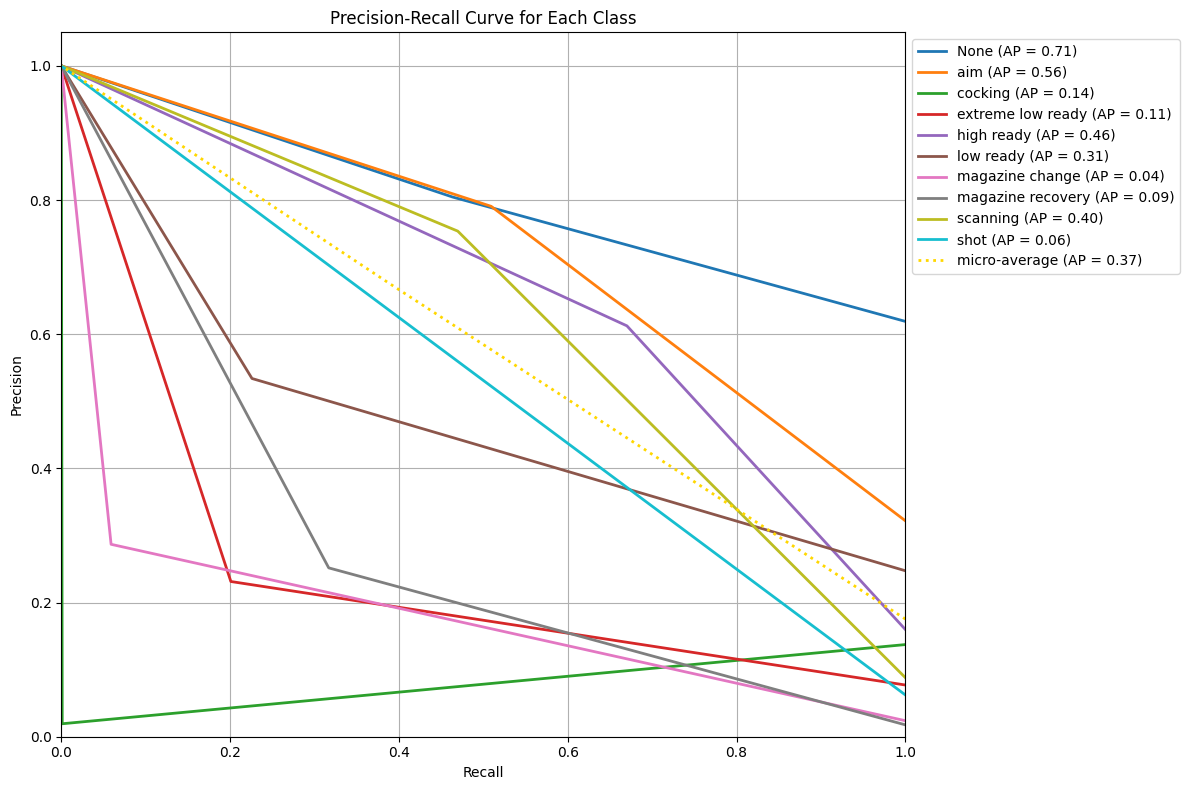

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt

y_true = test_labels
y_pred = binary_pred
num_labels = len(all_classes)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Compute micro-average precision-recall curve and area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred, average="micro")

plt.figure(figsize=(12, 8))
plt.grid(True)

# Plot individual class precision-recall curves
for i, label in enumerate(mlb.classes_):
    plt.plot(recall[i], precision[i], lw=2, label='%s (AP = %0.2f)' % (label, average_precision[i]))

# Plot micro-average curve
plt.plot(recall["micro"], precision["micro"], lw=2, color='gold', linestyle=':', label='micro-average (AP = {0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_mat = confusion_matrix(test_labels, binary_pred)


ValueError: ignored

In [ ]:
import pandas as pd

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(confusion_mat, index=mlb.classes_, columns=mlb.classes_)


(25167, 10)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.savefig("M4_2-5_CM.jpg")

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report


y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(test_labels, axis=-1)

print(classification_report(y_true_classes, y_pred_classes))


863/863 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.67      0.63      0.65     10330
           1       0.75      0.86      0.80      3785
           2       0.46      0.42      0.44      3827
           3       0.24      0.51      0.33       744
           4       0.39      0.41      0.40      1507
           5       0.82      0.69      0.75      3582
           6       0.19      0.26      0.22       739
           7       0.59      0.72      0.65      1344
           8       0.88      0.74      0.80      1460
           9       0.00      0.00      0.00       270

    accuracy                           0.62     27588
   macro avg       0.50      0.52      0.50     27588
weighted avg       0.63      0.62      0.62     27588



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np

# Assuming the model's output is one-hot encoded (e.g., using `to_categorical`)
# You can use np.argmax to convert the one-hot encoded predictions and labels back to class indices.
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Get the list of unique class labels
class_labels = np.unique(y_true_classes)

# Calculate accuracy for each class
class_accuracy = {}
for index, label in zip(class_labels, all_classes):
    correct_preds = np.where((y_true_classes == index) & (y_pred_classes == index))[0]
    class_accuracy[label] = len(correct_preds) / np.sum(y_true_classes == index)

print("Accuracy for each class:")
for label, accuracy in class_accuracy.items():
    print(f"Class {label}: {accuracy:.4f}")


Accuracy for each class:
Class None: 0.6306
Class aim: 0.8602
Class cocking: 0.4207
Class extreme low ready: 0.5081
Class high ready: 0.4134
Class low ready: 0.6854
Class magazine change: 0.2585
Class magazine recovery: 0.7225
Class scanning: 0.7404
Class shot: 0.0000
